In [1]:
import os
import sys
import csv
import random
import math
import operator
import numpy as np

os.chdir('/Users/karolinagrzeszkiewicz/robustness-tests/locomotion')
import locomotion
import locomotion.extendedDTW as extendedDTW
import locomotion.write as write
import locomotion.animal as animal
from locomotion.animal import throwError
from scipy.signal import savgol_filter
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
FR_high_sequence = []
for i in range(24, 120, 2):
    FR_high_sequence.append(i)
    
FR_low_sequence = []
for i in range(6, 24, 1):
    FR_low_sequence.append(i)

In [3]:
#useful functions from trajectory.py
def getDerivatives(X, axis = 0):
  """
  Computes the derivative of the series X. Returns a numpy array
  """
  dX = np.gradient(X, axis = axis)
  return dX

def getVelocity(V):
  """
  Calculate the velocity
  :Parameters:
  V : list
  :Return:
  nV : list
  """
  nV = np.sqrt(np.sum(np.power(V, 2), axis = 0))
  return nV

def getCurvature(d1, d2, V):
  """
  Given a list of first and second derivatives, return curvature.
  Note: Currently only works for up to 2 / 3 dimensions.

  :Parameters:
  d1: numpy array
  d2: numpy array
  V: numpy array
  :Return:
  C : numpy array
  """
  if d1.shape != d2.shape:
    raise Exception("d1 and d2 should be of the same shape.")
  n_dims = d1.shape[0]
  if n_dims == 2:
    mats = np.transpose(np.array([d1,d2]), (2,0,1))
  elif n_dims == 3:
    d0 = np.ones_like(d1)
    mats = np.transpose(np.array([d0,d1,d2]), (2,0,1))
  numer = np.absolute(np.linalg.det(mats))
  denom = np.power(V,3)
  C = []
  for i in range(len(numer)):
    if denom[i] < 0.000125:
      c = 0
    else:
      c = numer[i]/denom[i]
    C.append(c)
  
  return C

In [49]:
#relevant functions: code copied from capture_and_compare

import os
import re
import sys
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import locomotion

#creating necessary folders for storing data / results
PATH_TO_DATA_DIRECTORY = os.getcwd() + "/data"
try: # Safety check to ensure that data folder exists, and makes it otherwise.
    os.mkdir(PATH_TO_DATA_DIRECTORY)
except FileExistsError:
    pass

PATH_TO_RES_DIRECTORY = os.getcwd() + "/results"
try: # Safety check to ensure that results folder exists, and makes it otherwise.
    os.mkdir(PATH_TO_RES_DIRECTORY)
except FileExistsError:
    pass


#static variables used for robustness testing
NUM_CURVES = 50 # This must match the number of curves in the data/curve_data directory.
ZFILL_LEN = int(np.ceil(np.log10(NUM_CURVES)))
NUM_SAMPLES = 50 # Number of samples being tested
SAMP_FILL = int(np.ceil(np.log10(NUM_SAMPLES)))
DEFAULT_START = 0 # Start Time in Minutes
DEFAULT_STOP = 1 # Stop Time in Minutes

########################################################################
#### Functions for getting curve data  ####
########################################################################

def genTrigFun(a_k, b_k):
    """ Generates the Fourier series function f(theta) = sum_0^k (a_k * cos(k * theta) + b_k * sin(k * theta))
        based on the given coefficient sequences.
        :Parameters:
            a_k/b_k : float list. Coefficient sequences of length k.
        :Returns:
            function f(theta), which is defined by f(theta) = sum_0^k (a_k * cos(k * theta) + b_k * sin(k * theta)).
    """

    #define the function we want to return
    def fun_theta (theta):
        #initialise the sum of all k terms
        cum_sum = 0

        #add each term of the function to the sum iteratively
        for i in range(len(a_k)):
            cum_sum += a_k[i] * np.sin(i * theta) + b_k[i] * np.cos(i * theta)
        return cum_sum

    return (fun_theta)

def changePixDensity(num, density):
    """ Converts a coordinate given in mm (num) to the corresponding coordinate in pixels, given the pixel density.
        This is used as part of cameraFunc to translate the coordinates in mm to pixels based on the camera settings.
        :Parameters:
            num : float. Coordinate value, in mm.
            density: float. Pixel Density of given file, in px/mm.
        :Returns:
            float. Corresponding coordinate value, in px.
    """
    #initialise return value
    result = 0

    #if our values aren't edge cases, return the corresponding value discretised to the given pixel density
    if not (num == 0 or density == 0 or math.isnan(num) or math.isnan(density)):
        result = math.floor(num * density)

    return result


def genVariables(low, high, n):
    """ Uniformly samples n values from given interval. Utility function for generating test variables.
        :Parameters:
            low : float. Lower bound of interval.
            high : float. Upper bound of interval.
            n : int. Number of samples.
        :Returns:
            list of n floats. The uniformly sampled values within the interval.
    """
    return list(np.random.uniform(low, high, n))

In [54]:
def PlotCurve(curve, FR, ORDER, c, mode = 'coords', zoom_in_for_fr_range=None, animal_obj2 = None, zoom_in_for_fr2_range = None):
    

    #plots x and y coordinates of curve (curve) 
    #provide  zoom_in_for_fr2_range to specify the frame range for the extra plot
    #provide extra data to plot: original curve, and curve captured with fr and density
    
    #ORDER: order of the polynomials in Savitzky-Golai smoothing
    #c: window length (in Sav-Gol smoothing) = c * FR
    
    #get animal_obj
    curve_str = '%02d' % curve
    if FR in FR_low_sequence:
        test_name = "FR_test_lower"
        idx = FR_low_sequence.index(FR)+1
    elif FR in FR_high_sequence:
        test_name = "FR_test_higher"
        idx = FR_high_sequence.index(FR)+1
    info_file = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/"+test_name+"/CRV_"+curve_str+".json"
    animals = animal.getAnimalObjs(info_file)
    #animal_ctrl = animals[0]
    animal_obj = animals[idx]
    
    SMOOTH_RANGE_MIN = 5
    FR = animal_obj.getFrameRate()
    
    def smooth(X, frame_rate):
    # Smoothes the sequence X by applying Savitzky-Golay smoothing
    
        r = max(SMOOTH_RANGE_MIN, int(np.ceil(c*frame_rate)))
        SMOOTH_RANGE = r + 1 if r % 2 == 0 else r
        sX = savgol_filter(X,SMOOTH_RANGE, ORDER)
        return sX
    
    def getCurveData( animal_obj , col_names = ['X', 'Y']):
    #Computes the behavioural curve data such as Velocity and Curvature .
      
        n_dims = len(col_names)
        if n_dims < 2 or n_dims > 3:
            raise Exception("length of col_names is {}, but it should be 2 or 3.".format(n_dims))
        coords = []
        for col in col_names:
            try:
                coords.append(smooth(animal_obj.getRawVals(col), animal_obj.getFrameRate()))
            except KeyError:
                raise Exception("column name {} does not exist in animal dataset".format(col))

        x = animal_obj.getRawVals('X') #MM
        y = animal_obj.getRawVals('Y') #MM
        #original coordinates as captured bny camera but converted to mm 
        #(divided by pixel density = 2 px/mm (in case of FR test))
        coords = np.array(coords) # MM (smoothed coordinates)
        d1 = getDerivatives(coords, axis = 1) # MM per frame
        d1 = d1 * animal_obj.getFrameRate() # MM per second
        d2 = getDerivatives(d1, axis = 1) # MM per second per frame
        d2 = d2 * animal_obj.getFrameRate() # MM per second per second
        V = getVelocity(d1)
        C = getCurvature(d1, d2, V)

        st, et = animal_obj.getBaselineTimes()
        animal_obj.addRawVals('Velocity', V)
        animal_obj.addStats('Velocity', 'baseline', st, et)
        animal_obj.addRawVals('Curvature', C)
        animal_obj.addStats('Curvature', 'baseline', st, et)

        return x, y, coords, d1, d2, V, C

    
    #obtain relevant data frame for given curve and FR
    x, y, coords, d1, d2, V, C = getCurveData(animal_obj , col_names = ['X', 'Y'])
    FR = animal_obj.getFrameRate()
    
    if zoom_in_for_fr_range is None:
        zoom_in_for_fr_range = range(len(V))
    
 
    #change the range of frames depending on which time/frame interval we want to zoom in to
    x = x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    y = y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    coordsx = coords[0]
    coordsx = coordsx[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    coordsy = coords[1]
    coordsy = coordsy[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d1x = d1[0]
    d1x = d1x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d1y = d1[1]
    d1y = d1y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d2x = d2[0]
    d2x = d2x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d2y = d2[1]
    d2y = d2y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    V = V[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    C = C[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    
    #get data for the original coordinates of the generated curve
    
    #read in data from the corresponding coefficients csv file
    curve_str = '%02d' % curve
    coeff_path = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/data/curve_data/coefficients_"+curve_str+".csv"
    data = pd.read_csv(coeff_path)

    #coefficients - each are sequences of length k
    #a_k, b_k are used for x(theta) and c_k, d_k are used for y(theta)
    a_k = data['a_k'].values
    b_k = data['b_k'].values
    c_k = data['c_k'].values
    d_k = data['d_k'].values

    #extras
    #maximum theta value for input into the trig function
    max_theta = data['extras'][0]
    #size is the full dimensions of the camera, whereas x/y min/max/diff are the corresponding
    #dimensions for the bounding box that will contain the curve. All values currently in mm.
    size = data['extras'][1]
    x_min = data['extras'][2]
    x_max = data['extras'][3]
    x_diff = x_max - x_min
    y_min = data['extras'][4]
    y_max = data['extras'][5]
    y_diff = y_max - y_min

    #calculate total frames
    #total_frames = (time_stop - time_start) * frame_rate
    #partition the interval [0, max_theta] into total_frame steps, generating 1 theta per frame
    #to be used in the parametric function.
    thetas = max_theta * np.arange(0, 1, 1/50000)
    #50 000 instead of frames, must be large enough to get a smooth curves
    #generate trig functions for x, y coordinates. Each function's domain is theta in [0, 2pi]
    x_fun = genTrigFun(a_k, b_k)
    y_fun = genTrigFun(c_k, d_k)

    #calculate x, y coordinates (in mm) using thetas, and calculate min/max for scaling/translation
    x_og = x_fun(thetas)
    y_og = y_fun(thetas)
    lower_xlim = min(x_og)
    upper_xlim = max(x_og)
    lower_ylim = min(y_og)
    upper_ylim = max(y_og)

    #translate and scale the coordinates to fit into the generated bounding box while preserving shape
    x_enlarged = []
    y_enlarged = []
    for i in range(0, 50000):
        x_enlarged.append((x_diff / (upper_xlim - lower_xlim)) * (x_og[i] - lower_xlim) + x_min)
        y_enlarged.append((y_diff / (upper_ylim - lower_ylim)) * (y_og[i] - lower_ylim) + y_min)
        
    ratio = (len(zoom_in_for_fr_range))/(60*FR)
    low_limit = int(((zoom_in_for_fr_range[0])/(60*FR))*50000)
    high_limit = int(((zoom_in_for_fr_range[-1])/(60*FR))*50000)
    x_enlarged = x_enlarged[low_limit:high_limit]
    y_enlarged = y_enlarged[low_limit:high_limit]
        
    #set plot size and axis
    fig=plt.figure(figsize = (50,25))
    ax=fig.add_axes([0,0,1,1])
    
    if mode == 'coords':
        ax.scatter(x, y, color = 'r', s = 20, label = 'captured coordinates (mm), FR =' + str(FR))
        ax.scatter(coordsx, coordsy, color='b', s = 20, label = 'smoothed coordinates (mm), FR =' + str(FR))
        ax.scatter(x_enlarged, y_enlarged, color = 'c', s = 17, label = 'original coordinates (mm)')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    elif mode == 'velocity':
        ax.scatter(range(len(V)), V, color='c', s = 20, label = 'Velocity, FR = ' + str(FR))
    elif mode == 'curvature':
        ax.scatter(range(len(C)), C, color='b', s = 20, label = 'Curvature, FR = ' + str(FR)) 
    elif mode == 'derivatives':
        ax.scatter(range(len(d1x)), d1x, color='c', s = 20, label = 'dx (mm/sec), FR = ' + str(FR))
        ax.scatter(range(len(d1y)), d1y, color='g', s = 20, label = 'dy (mm/sec), FR = ' + str(FR))
        
    if animal_obj2 != None:
        x2, y2, coords2, d12, d22, V2, C2 = getCurveData(animal_obj2 , col_names = ['X', 'Y'])
        FR2 = animal_obj2.getFrameRate()
        if zoom_in_for_fr_range2 is None:
            zoom_in_for_fr_range2 = range(0, len(V2))
        
        #change the range of frames depending on which time/frame interval we want to zoom in to
        x2 = x2[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        y2 = y2[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        coords2x = coords2[0]
        coords2x = coords2x[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        coords2y = coords2[1]
        coords2y = coords2y[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d12x = d12[0]
        d12x = d12x[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d12y = d12[1]
        d12y = d12y[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d22x = d22[0]
        d22x = d22x[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d22y = d22[1]
        d22y = d22y[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        V2 = V2[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        C2 = C2[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        
        if mode == 'coords':
            ax.scatter(x2, y2, color = 'o', s = 20, label = 'captured coordinates (mm), FR =' + str(FR))
            ax.scatter(coords2x, coords2y, color='g', s = 12, label = 'smoothed coordinates (mm), FR =' + str(FR2))
        elif mode == 'velocity':
            ax.scatter(range(len(V2)), V2, color='m', s = 12, label = 'Velocity, FR =' + str(FR2))
        elif mode == 'curvature':
            ax.scatter(range(len(C2)), C2, color='k', s = 12, label = 'Curvature, FR =' + str(FR2)) 
        elif mode == 'derivatives':
            ax.scatter(range(len(d12x)), d12x, color='o', s = 12, label = 'dx (mm/sec), FR =' + str(FR2))
            ax.scatter(range(len(d12y)), d12y, color='r', s = 12, label = 'dy (mm/sec), FR =' + str(FR2))
        
        
    #add labels and legend
    plt.legend(prop={'size': 50})

    plt.show()

In [17]:
def PlotCurve_const_window(curve, FR, ORDER, k, mode = 'coords', zoom_in_for_fr_range=None, animal_obj2 = None, zoom_in_for_fr2_range = None):
    
# SAME AS ABOVE BUT SMOOTHING WINDOW IN SAV-GOL IS CONST AND = k (parameter), rather than a linear fun of FR 
    #plots x and y coordinates of curve (curve) 
    #provide  zoom_in_for_fr2_range to specify the frame range for the extra plot
    #provide extra data to plot: original curve, and curve captured with fr and density
    
    #ORDER: order of the polynomials in Savitzky-Golai smoothing
    #c: window length (in Sav-Gol smoothing) = c * FR
    
    #get animal_obj
    curve_str = '%02d' % curve
    if FR in FR_low_sequence:
        test_name = "FR_test_lower"
        idx = FR_low_sequence.index(FR)+1
    elif FR in FR_high_sequence:
        test_name = "FR_test_higher"
        idx = FR_high_sequence.index(FR)+1
    info_file = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/"+test_name+"/CRV_"+curve_str+".json"
    animals = animal.getAnimalObjs(info_file)
    #animal_ctrl = animals[0]
    animal_obj = animals[idx]
    
    SMOOTH_RANGE_MIN = 5
    FR = animal_obj.getFrameRate()
    
    def smooth(X):
    # Smoothes the sequence X by applying Savitzky-Golay smoothing
    
        r = max(SMOOTH_RANGE_MIN, k)
        SMOOTH_RANGE = r + 1 if r % 2 == 0 else r
        sX = savgol_filter(X,SMOOTH_RANGE, ORDER)
        return sX
    
    def getCurveData( animal_obj , col_names = ['X', 'Y']):
    #Computes the behavioural curve data such as Velocity and Curvature .
      
        n_dims = len(col_names)
        if n_dims < 2 or n_dims > 3:
            raise Exception("length of col_names is {}, but it should be 2 or 3.".format(n_dims))
        coords = []
        for col in col_names:
            try:
                coords.append(smooth(animal_obj.getRawVals(col)))
            except KeyError:
                raise Exception("column name {} does not exist in animal dataset".format(col))

        x = animal_obj.getRawVals('X') #MM
        y = animal_obj.getRawVals('Y') #MM
        #original coordinates as captured bny camera but converted to mm 
        #(divided by pixel density = 2 px/mm (in case of FR test))
        coords = np.array(coords) # MM (smoothed coordinates)
        d1 = getDerivatives(coords, axis = 1) # MM per frame
        d1 = d1 * animal_obj.getFrameRate() # MM per second
        d2 = getDerivatives(d1, axis = 1) # MM per second per frame
        d2 = d2 * animal_obj.getFrameRate() # MM per second per second
        V = getVelocity(d1)
        C = getCurvature(d1, d2, V)

        st, et = animal_obj.getBaselineTimes()
        animal_obj.addRawVals('Velocity', V)
        animal_obj.addStats('Velocity', 'baseline', st, et)
        animal_obj.addRawVals('Curvature', C)
        animal_obj.addStats('Curvature', 'baseline', st, et)

        return x, y, coords, d1, d2, V, C

    
    #obtain relevant data frame for given curve and FR
    x, y, coords, d1, d2, V, C = getCurveData(animal_obj , col_names = ['X', 'Y'])
    FR = animal_obj.getFrameRate()
    
    if zoom_in_for_fr_range is None:
        zoom_in_for_fr_range = range(len(V))
    
    print(zoom_in_for_fr_range)
 
    #change the range of frames depending on which time/frame interval we want to zoom in to
    x = x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    y = y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    coordsx = coords[0]
    coordsx = coordsx[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    coordsy = coords[1]
    coordsy = coordsy[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d1x = d1[0]
    d1x = d1x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d1y = d1[1]
    d1y = d1y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d2x = d2[0]
    d2x = d2x[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    d2y = d2[1]
    d2y = d2y[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    V = V[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    C = C[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
    
    print(len(coordsx))
    print(len(coordsy))
    
    #set plot size and axis
    fig=plt.figure(figsize = (50,25))
    ax=fig.add_axes([0,0,1,1])
    
    if mode == 'coords':
        ax.scatter(x, y, color = 'r', s = 20, label = 'captured coordinates (mm), FR =' + str(FR))
        ax.scatter(coordsx, coordsy, color='b', s = 20, label = 'smoothed coordinates (mm), FR =' + str(FR))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
    elif mode == 'velocity':
        ax.scatter(range(len(V)), V, color='c', s = 20, label = 'Velocity, FR = ' + str(FR))
    elif mode == 'curvature':
        ax.scatter(range(len(C)), C, color='b', s = 20, label = 'Curvature, FR = ' + str(FR)) 
    elif mode == 'derivatives':
        ax.scatter(range(len(d1x)), d1x, color='c', s = 20, label = 'dx (mm/sec), FR = ' + str(FR))
        ax.scatter(range(len(d1y)), d1y, color='g', s = 20, label = 'dy (mm/sec), FR = ' + str(FR))
        
    if animal_obj2 != None:
        x2, y2, coords2, d12, d22, V2, C2 = getCurveData(animal_obj2 , col_names = ['X', 'Y'])
        FR2 = animal_obj2.getFrameRate()
        if zoom_in_for_fr_range2 is None:
            zoom_in_for_fr_range2 = range(0, len(V2))
        
        #change the range of frames depending on which time/frame interval we want to zoom in to
        x2 = x2[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        y2 = y2[zoom_in_for_fr_range[0]:zoom_in_for_fr_range[-1]+1]
        coords2x = coords2[0]
        coords2x = coords2x[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        coords2y = coords2[1]
        coords2y = coords2y[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d12x = d12[0]
        d12x = d12x[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d12y = d12[1]
        d12y = d12y[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d22x = d22[0]
        d22x = d22x[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        d22y = d22[1]
        d22y = d22y[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        V2 = V2[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        C2 = C2[zoom_in_for_fr_range2[0]:zoom_in_for_fr_range2[-1]+1]
        
        if mode == 'coords':
            ax.scatter(x2, y2, color = 'o', s = 20, label = 'captured coordinates (mm), FR =' + str(FR))
            ax.scatter(coords2x, coords2y, color='g', s = 12, label = 'smoothed coordinates (mm), FR =' + str(FR2))
        elif mode == 'velocity':
            ax.scatter(range(len(V2)), V2, color='m', s = 12, label = 'Velocity, FR =' + str(FR2))
        elif mode == 'curvature':
            ax.scatter(range(len(C2)), C2, color='k', s = 12, label = 'Curvature, FR =' + str(FR2)) 
        elif mode == 'derivatives':
            ax.scatter(range(len(d12x)), d12x, color='o', s = 12, label = 'dx (mm/sec), FR =' + str(FR2))
            ax.scatter(range(len(d12y)), d12y, color='r', s = 12, label = 'dy (mm/sec), FR =' + str(FR2))
        
        
    #add labels and legend
    plt.legend(prop={'size': 50})

    plt.show()

In [24]:
def getdata_const_window(curve, FR, ORDER, k, mode = 'coords', zoom_in_for_fr_range=None, animal_obj2 = None, zoom_in_for_fr2_range = None):
    
# SAME AS ABOVE BUT SMOOTHING WINDOW IN SAV-GOL IS CONST AND = k (parameter), rather than a linear fun of FR 
#to obtain arrays with curve data instead of a plot
    #plots x and y coordinates of curve (curve) 
    #provide  zoom_in_for_fr2_range to specify the frame range for the extra plot
    #provide extra data to plot: original curve, and curve captured with fr and density
    
    #ORDER: order of the polynomials in Savitzky-Golai smoothing
    #c: window length (in Sav-Gol smoothing) = c * FR
    
    #get animal_obj
    curve_str = '%02d' % curve
    if FR in FR_low_sequence:
        test_name = "FR_test_lower"
        idx = FR_low_sequence.index(FR)+1
    elif FR in FR_high_sequence:
        test_name = "FR_test_higher"
        idx = FR_high_sequence.index(FR)+1
    info_file = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/"+test_name+"/CRV_"+curve_str+".json"
    animals = animal.getAnimalObjs(info_file)
    #animal_ctrl = animals[0]
    animal_obj = animals[idx]
    
    SMOOTH_RANGE_MIN = 5
    FR = animal_obj.getFrameRate()
    
    def smooth(X):
    # Smoothes the sequence X by applying Savitzky-Golay smoothing
    
        r = max(SMOOTH_RANGE_MIN, k)
        SMOOTH_RANGE = r + 1 if r % 2 == 0 else r
        sX = savgol_filter(X,SMOOTH_RANGE, ORDER)
        return sX
    
    def getCurveData( animal_obj , col_names = ['X', 'Y']):
    #Computes the behavioural curve data such as Velocity and Curvature .
      
        n_dims = len(col_names)
        if n_dims < 2 or n_dims > 3:
            raise Exception("length of col_names is {}, but it should be 2 or 3.".format(n_dims))
        coords = []
        for col in col_names:
            try:
                coords.append(smooth(animal_obj.getRawVals(col)))
            except KeyError:
                raise Exception("column name {} does not exist in animal dataset".format(col))

        x = animal_obj.getRawVals('X') #MM
        y = animal_obj.getRawVals('Y') #MM
        #original coordinates as captured bny camera but converted to mm 
        #(divided by pixel density = 2 px/mm (in case of FR test))
        coords = np.array(coords) # MM (smoothed coordinates)
        d1 = getDerivatives(coords, axis = 1) # MM per frame
        d1 = d1 * animal_obj.getFrameRate() # MM per second
        d2 = getDerivatives(d1, axis = 1) # MM per second per frame
        d2 = d2 * animal_obj.getFrameRate() # MM per second per second
        V = getVelocity(d1)
        C = getCurvature(d1, d2, V)

        st, et = animal_obj.getBaselineTimes()
        animal_obj.addRawVals('Velocity', V)
        animal_obj.addStats('Velocity', 'baseline', st, et)
        animal_obj.addRawVals('Curvature', C)
        animal_obj.addStats('Curvature', 'baseline', st, et)

        return x, y, coords, d1, d2, V, C

    
    #obtain relevant data frame for given curve and FR
    x, y, coords, d1, d2, V, C = getCurveData(animal_obj , col_names = ['X', 'Y'])
    return x, y, coords, d1, d2, V, C

In [13]:
def computeBDDs(curve, test, ORDER, c):
    SMOOTH_RANGE_MIN = 5
    
    def smooth(X, FR):
    # Smoothes the sequence X by applying Savitzky-Golay smoothing
    
        r = max(SMOOTH_RANGE_MIN, int(np.ceil(c*FR)))
        SMOOTH_RANGE = r + 1 if r % 2 == 0 else r
        sX = savgol_filter(X,SMOOTH_RANGE, ORDER)
        return sX
    
    def getCurveData( animal_obj , col_names = ['X', 'Y']):
    #Computes the behavioural curve data such as Velocity and Curvature .
      
        n_dims = len(col_names)
        if n_dims < 2 or n_dims > 3:
            raise Exception("length of col_names is {}, but it should be 2 or 3.".format(n_dims))
        coords = []
        for col in col_names:
            try:
                coords.append(smooth(animal_obj.getRawVals(col), animal_obj.getFrameRate()))
            except KeyError:
                raise Exception("column name {} does not exist in animal dataset".format(col))

        x = animal_obj.getRawVals('X') #MM
        y = animal_obj.getRawVals('Y') #MM
        #original coordinates as captured bny camera but converted to mm 
        #(divided by pixel density = 2 px/mm (in case of FR test))
        coords = np.array(coords) # MM (smoothed coordinates)
        d1 = getDerivatives(coords, axis = 1) # MM per frame
        d1 = d1 * animal_obj.getFrameRate() # MM per second
        d2 = getDerivatives(d1, axis = 1) # MM per second per frame
        d2 = d2 * animal_obj.getFrameRate() # MM per second per second
        V = getVelocity(d1)
        C = getCurvature(d1, d2, V)

        st, et = animal_obj.getBaselineTimes()
        animal_obj.addRawVals('Velocity', V)
        animal_obj.addStats('Velocity', 'baseline', st, et)
        animal_obj.addRawVals('Curvature', C)
        animal_obj.addStats('Curvature', 'baseline', st, et)

        return coords, d1, d2, V, C
    
    def computeOneBDD(animal_obj_0, animal_obj_1, varnames, seg_start_time_0, seg_end_time_0, seg_start_time_1, seg_end_time_1, norm_mode, fullmode=False, outdir=None):
     

      #quick sanity check for output mode
        if fullmode and outdir == None:
            throwError("Full mode requires the path to output directory")

        seg_start_frame_0 = animal.getFrameNum(animal_obj_0, seg_start_time_0)
        seg_end_frame_0 = animal.getFrameNum(animal_obj_0, seg_end_time_0)
        data_0 = animal_obj_0.getMultRawVals(varnames, seg_start_frame_0, seg_end_frame_0)

        seg_start_frame_1 = animal.getFrameNum(animal_obj_1, seg_start_time_1)
        seg_end_frame_1 = animal.getFrameNum(animal_obj_1, seg_end_time_1)
        data_1 = animal_obj_1.getMultRawVals(varnames, seg_start_frame_1, seg_end_frame_1)

        print("LOG: Applying DTW to the data from files %s and %s..." % (animal_obj_0.getName(), animal_obj_1.getName()))

        numVars = len(varnames)

        if norm_mode == 'baseline':
            for i in range(numVars):
                m, s = animal_obj_0.getStats(varnames[i], 'baseline')
                data_0[i] = animal.normalize(data_0[i], m, s)
                m, s = animal_obj_1.getStats(varnames[i], 'baseline')
                data_1[i] = animal.normalize(data_1[i], m, s)
        elif norm_mode == 'spec':
            for i in range(numVars):
                m, s = animal.norm(data_0[i])
                data_0[i] = animal.normalize(data_0[i], m, s)
                m, s = animal.norm(data_1[i])
                data_1[i] = animal.normalize(data_1[i], m, s)
        dist, cost, alignment = extendedDTW.dtw_ext(data_0, data_1, dist_only=False)
      #dist is the integral part of the BDD formula
        scaler = len(alignment[0]) #arclength of the alignment
        bdd = dist/scaler
        print("LOG: distance between %s and %s: %.5f" % (animal_obj_0.getName(), animal_obj_1.getName(), bdd))

        if fullmode:
        #save alignment graphs in directory specified
            write.renderAlignment(alignment, animal_obj_0, animal_obj_1, varnames, outdir)
            for i in range(numVars): 
                v = varnames[i]
                if not os.path.exists(outdir): os.makedirs(outdir)
                write.renderAlignedGraphs(data_0[i], data_1[i], alignment, animal_obj_0, animal_obj_1, v, outdir)

          #For individual plots, enable the following two lines
          #write.renderSingleAnimalGraph(data_0[i], animal_obj_0, v, outdir)
          #write.renderSingleAnimalGraph(data_1[i], animal_obj_1, v, outdir)

        return bdd
    
    #get data
    curve_str = '%02d' % curve
    if test == 'low':
        test_name = "FR_test_lower"
        #idx = FR_sequence_low.index(FR)+1
    elif test == 'high' :
        test_name = "FR_test_higher"
        #idx = FR_sequence_high.index(FR)+1
    info_file = "/Users/karolinagrzeszkiewicz/robustness-tests/locomotion/tests/robustness_tests/results/"+test_name+"/CRV_"+curve_str+".json"
    animals = animal.getAnimalObjs(info_file)
    animal_ctrl = animals[0]
    #animal_obj = animals[idx]
    
    
    #getCurveData(animal_obj , col_names = ['X', 'Y'])
    getCurveData(animal_ctrl , col_names = ['X', 'Y'])
    BDDs = []
    for a in animals:
        if a != animal_ctrl:
            getCurveData(a, col_names = ['X', 'Y'])
            bdd = computeOneBDD(a, animal_ctrl, ['Velocity', 'Curvature'], 0, 1, 0, 1, 'spec')
            BDDs.append(bdd)
        
    #plot
    if test == 'low':
        xs = FR_low_sequence
    elif test == 'high':
        xs = FR_high_sequence

    plt.scatter(xs, BDDs, s=20)
    plt.xlabel('FR')
    plt.ylabel('BDD')
    plt.title('BDD values if smoothing function parametrised with order =' + str(ORDER)+', and window length = FR *' + str(c))
    plt.show()
    print(BDDs)
        

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

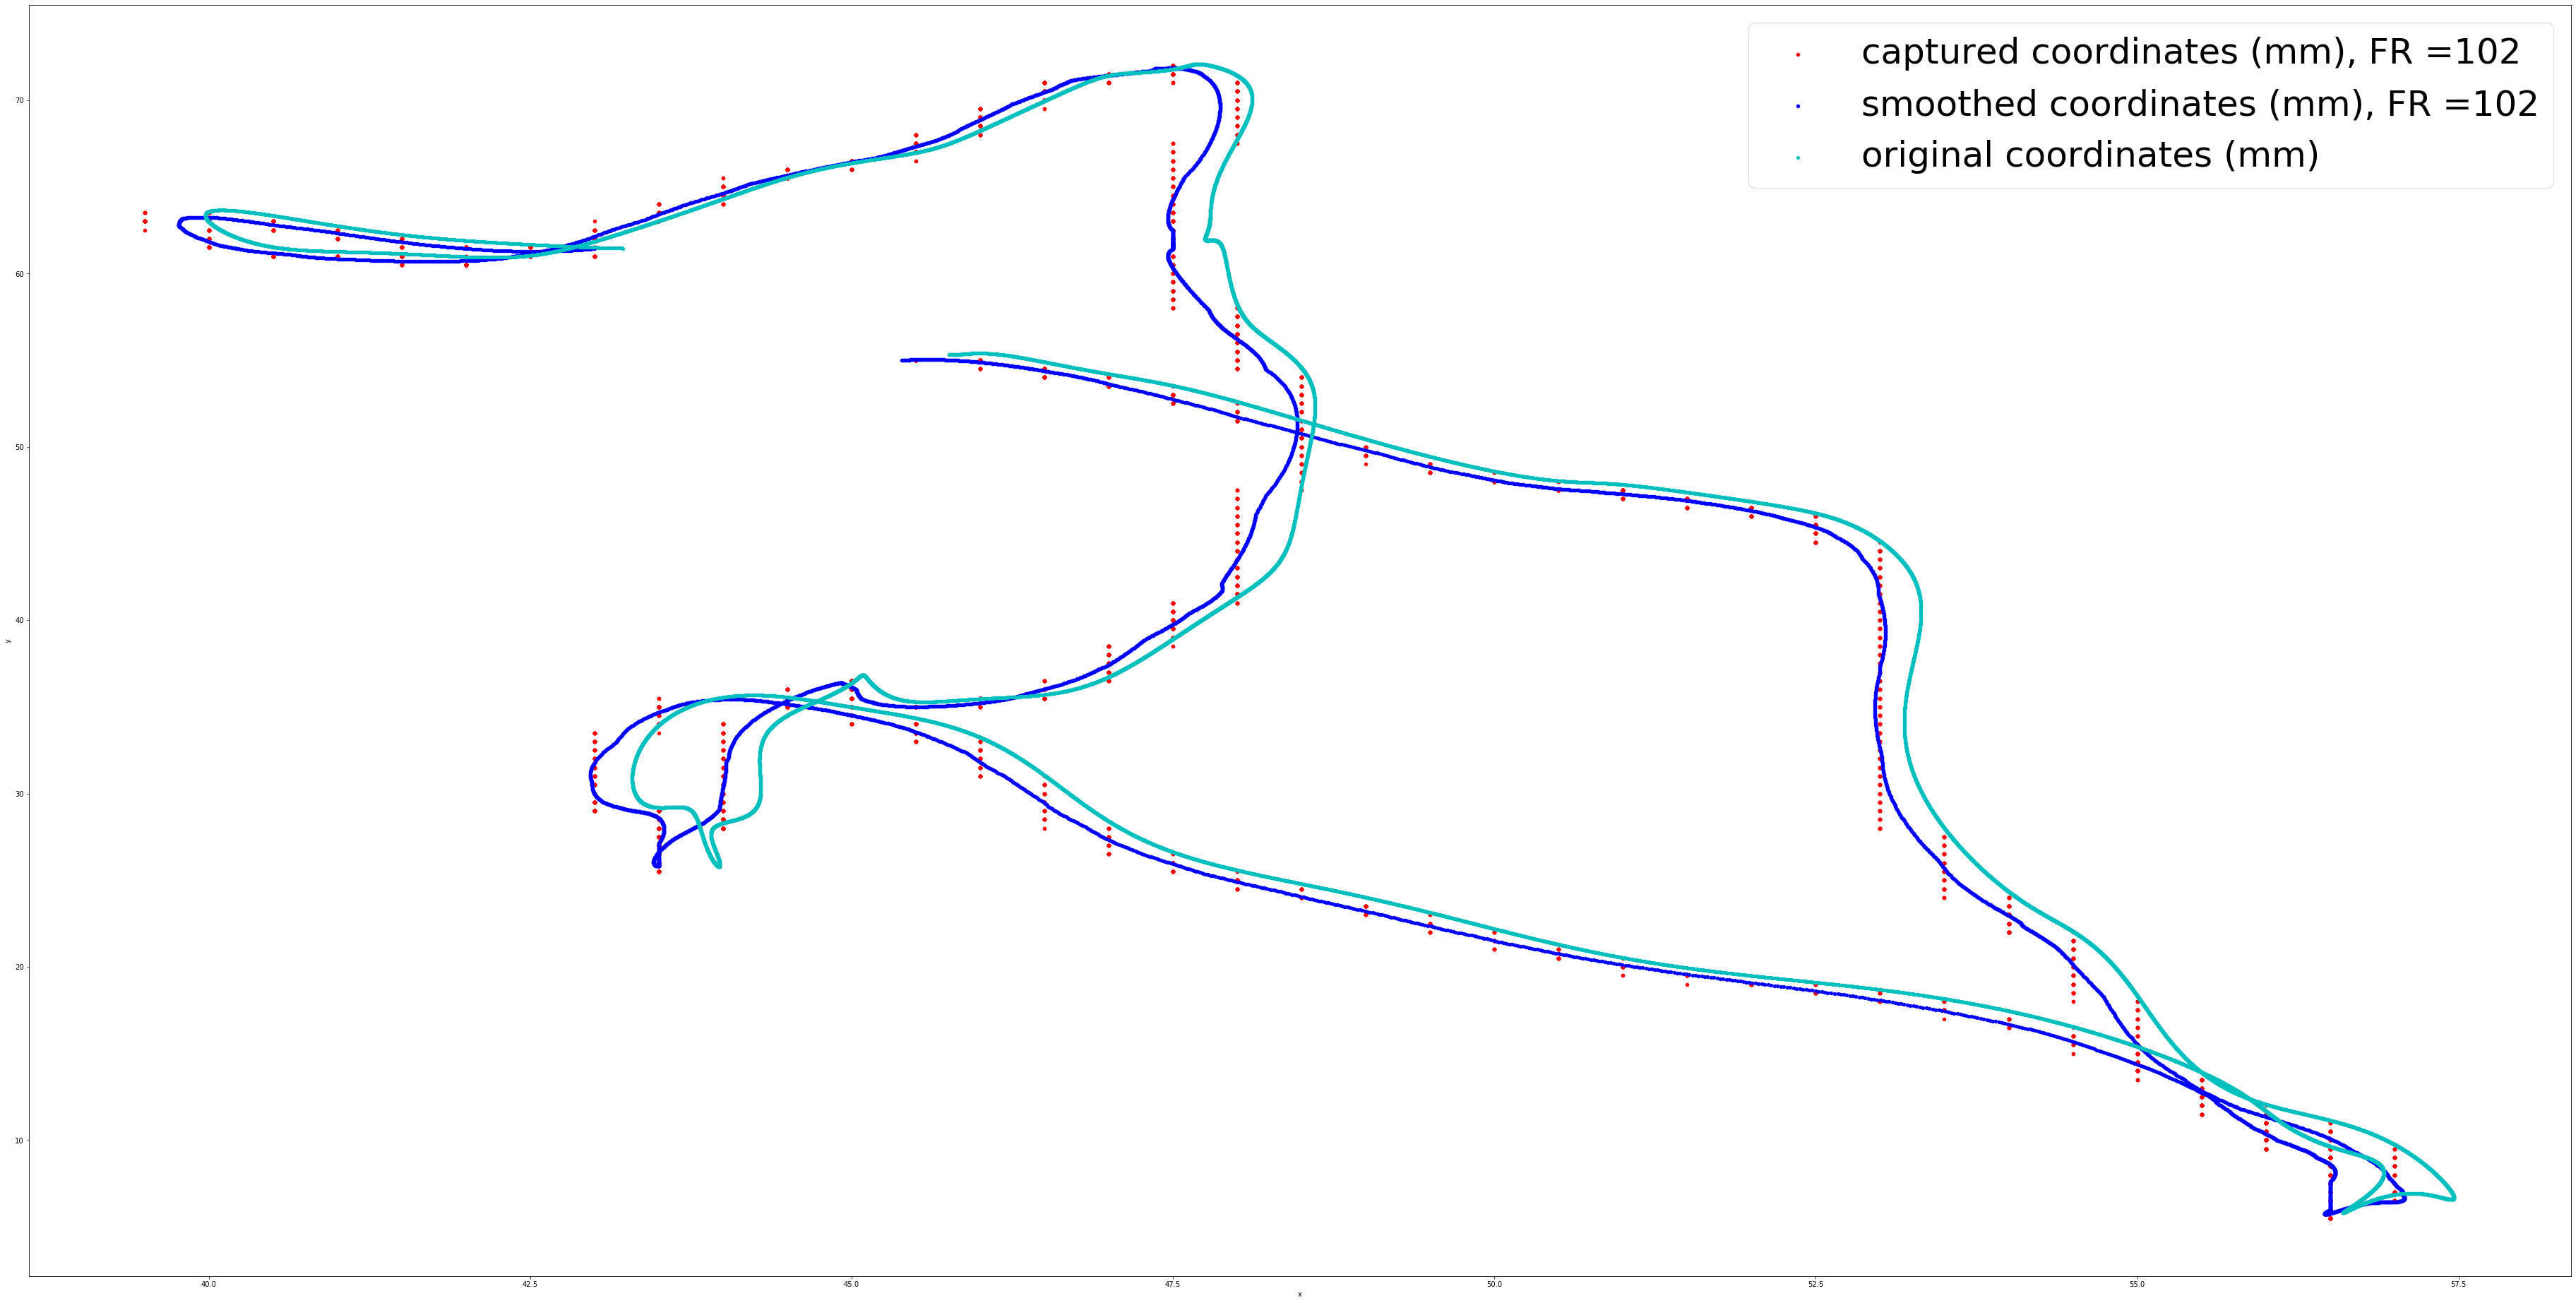

In [55]:
PlotCurve(34, 102, 3, 2.5)


LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

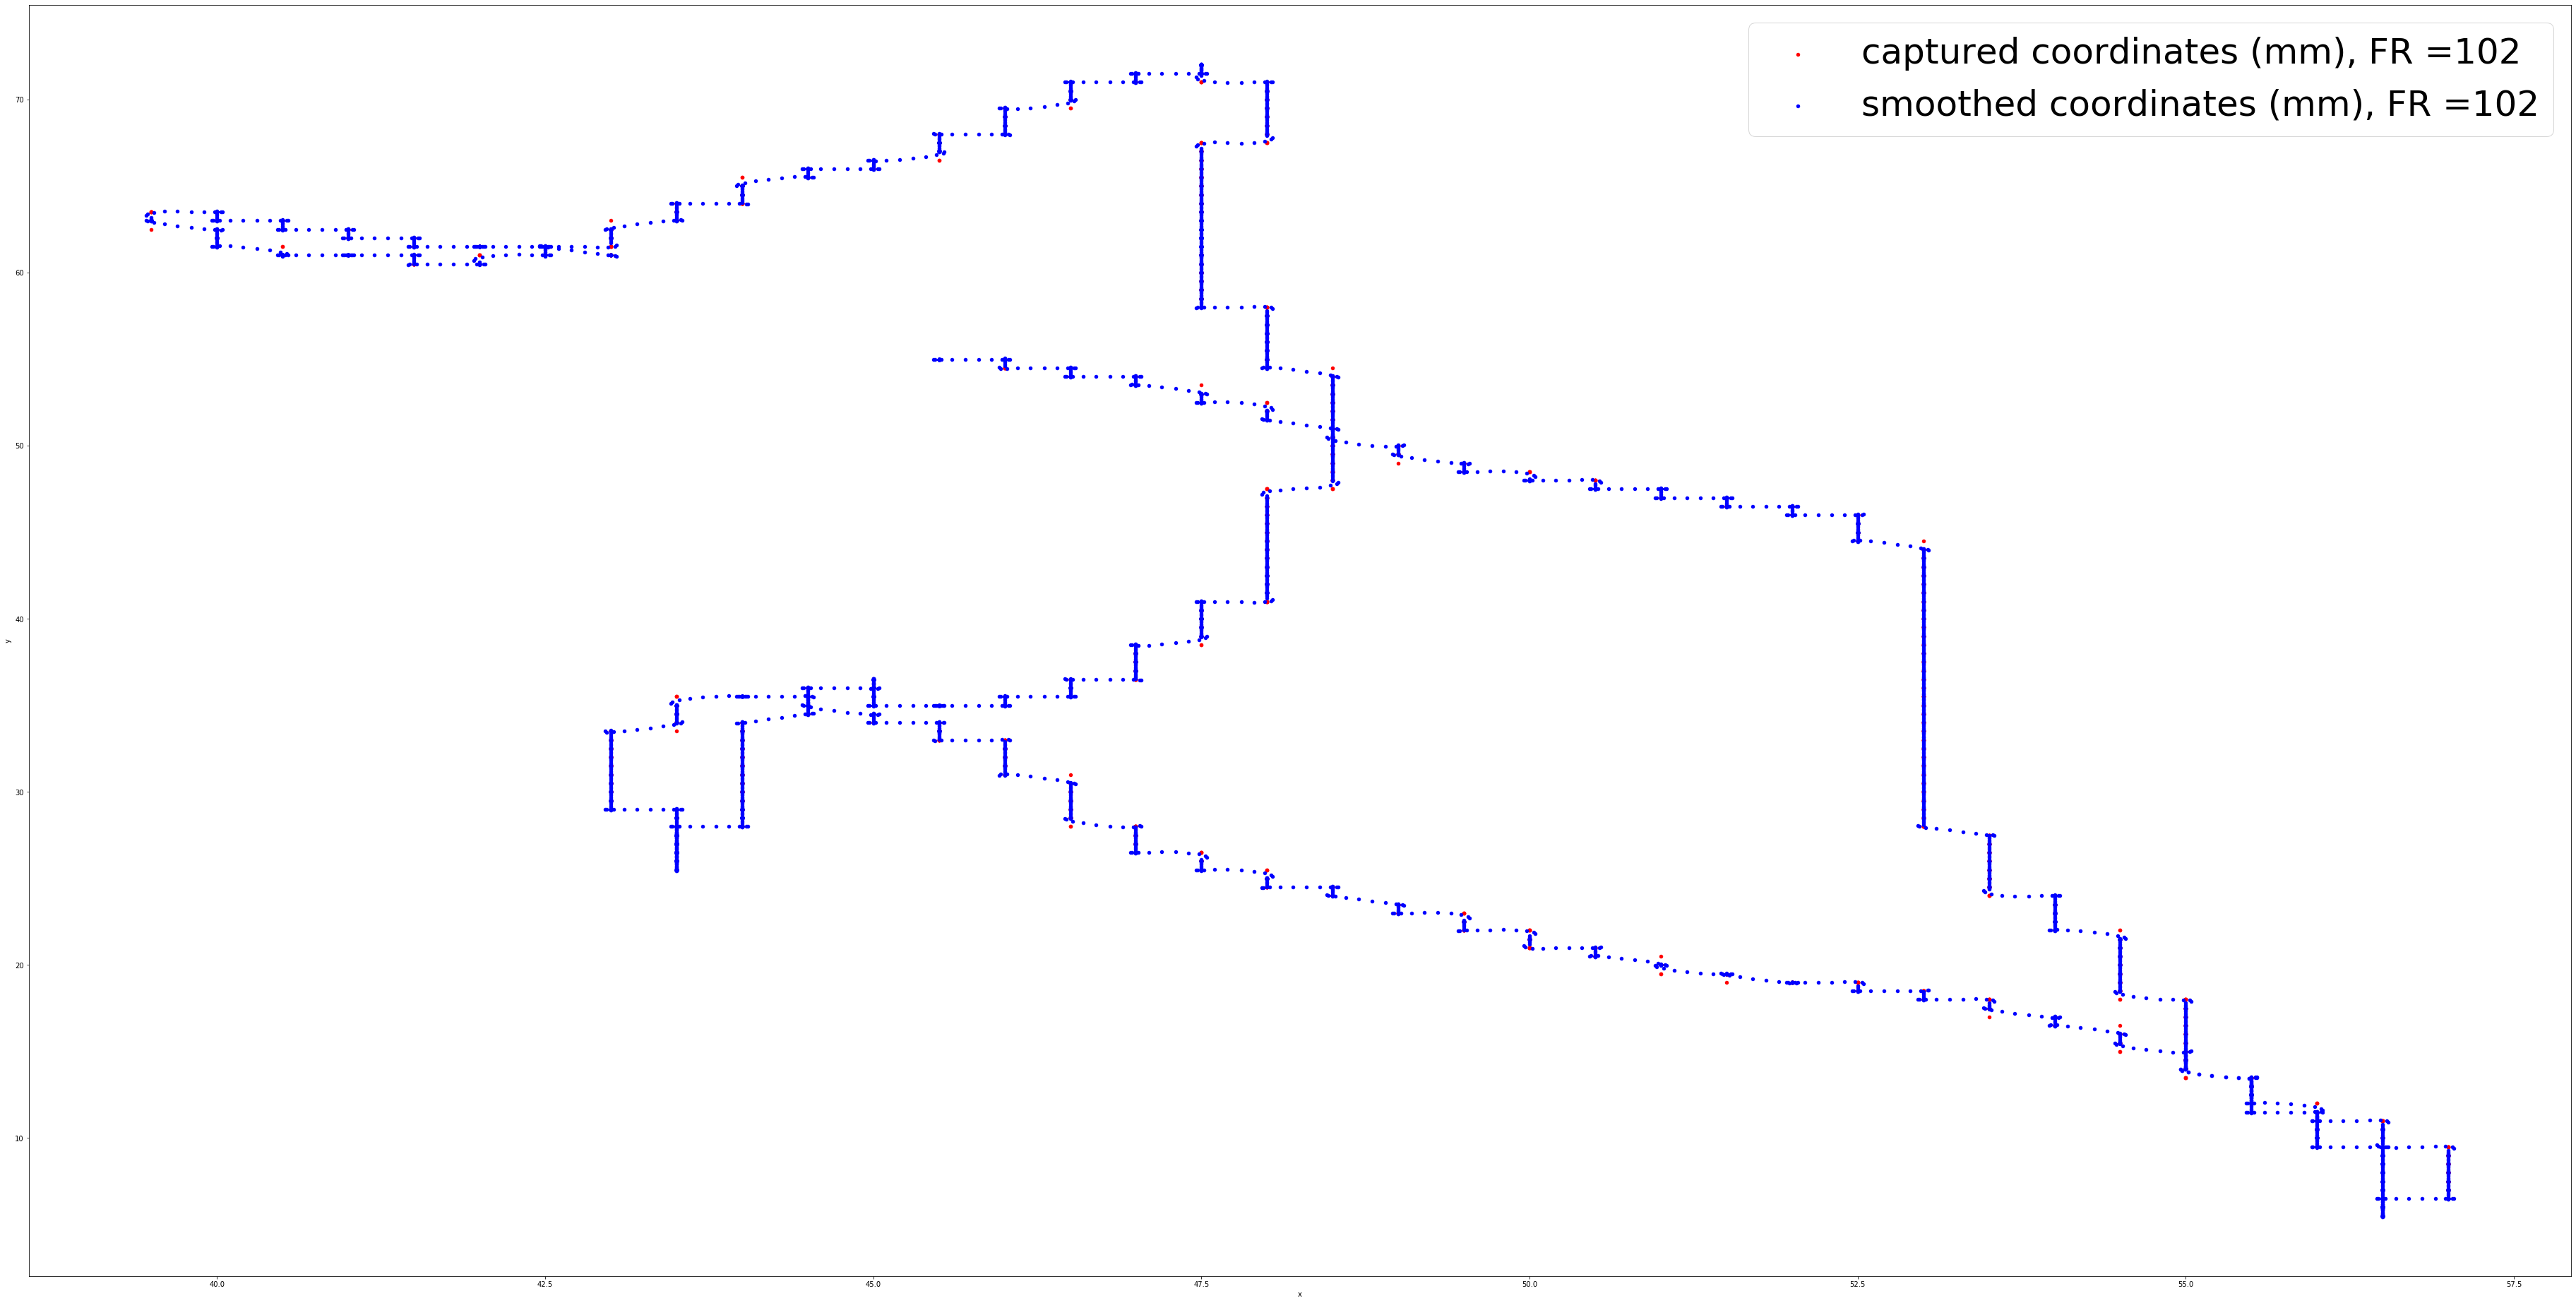

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

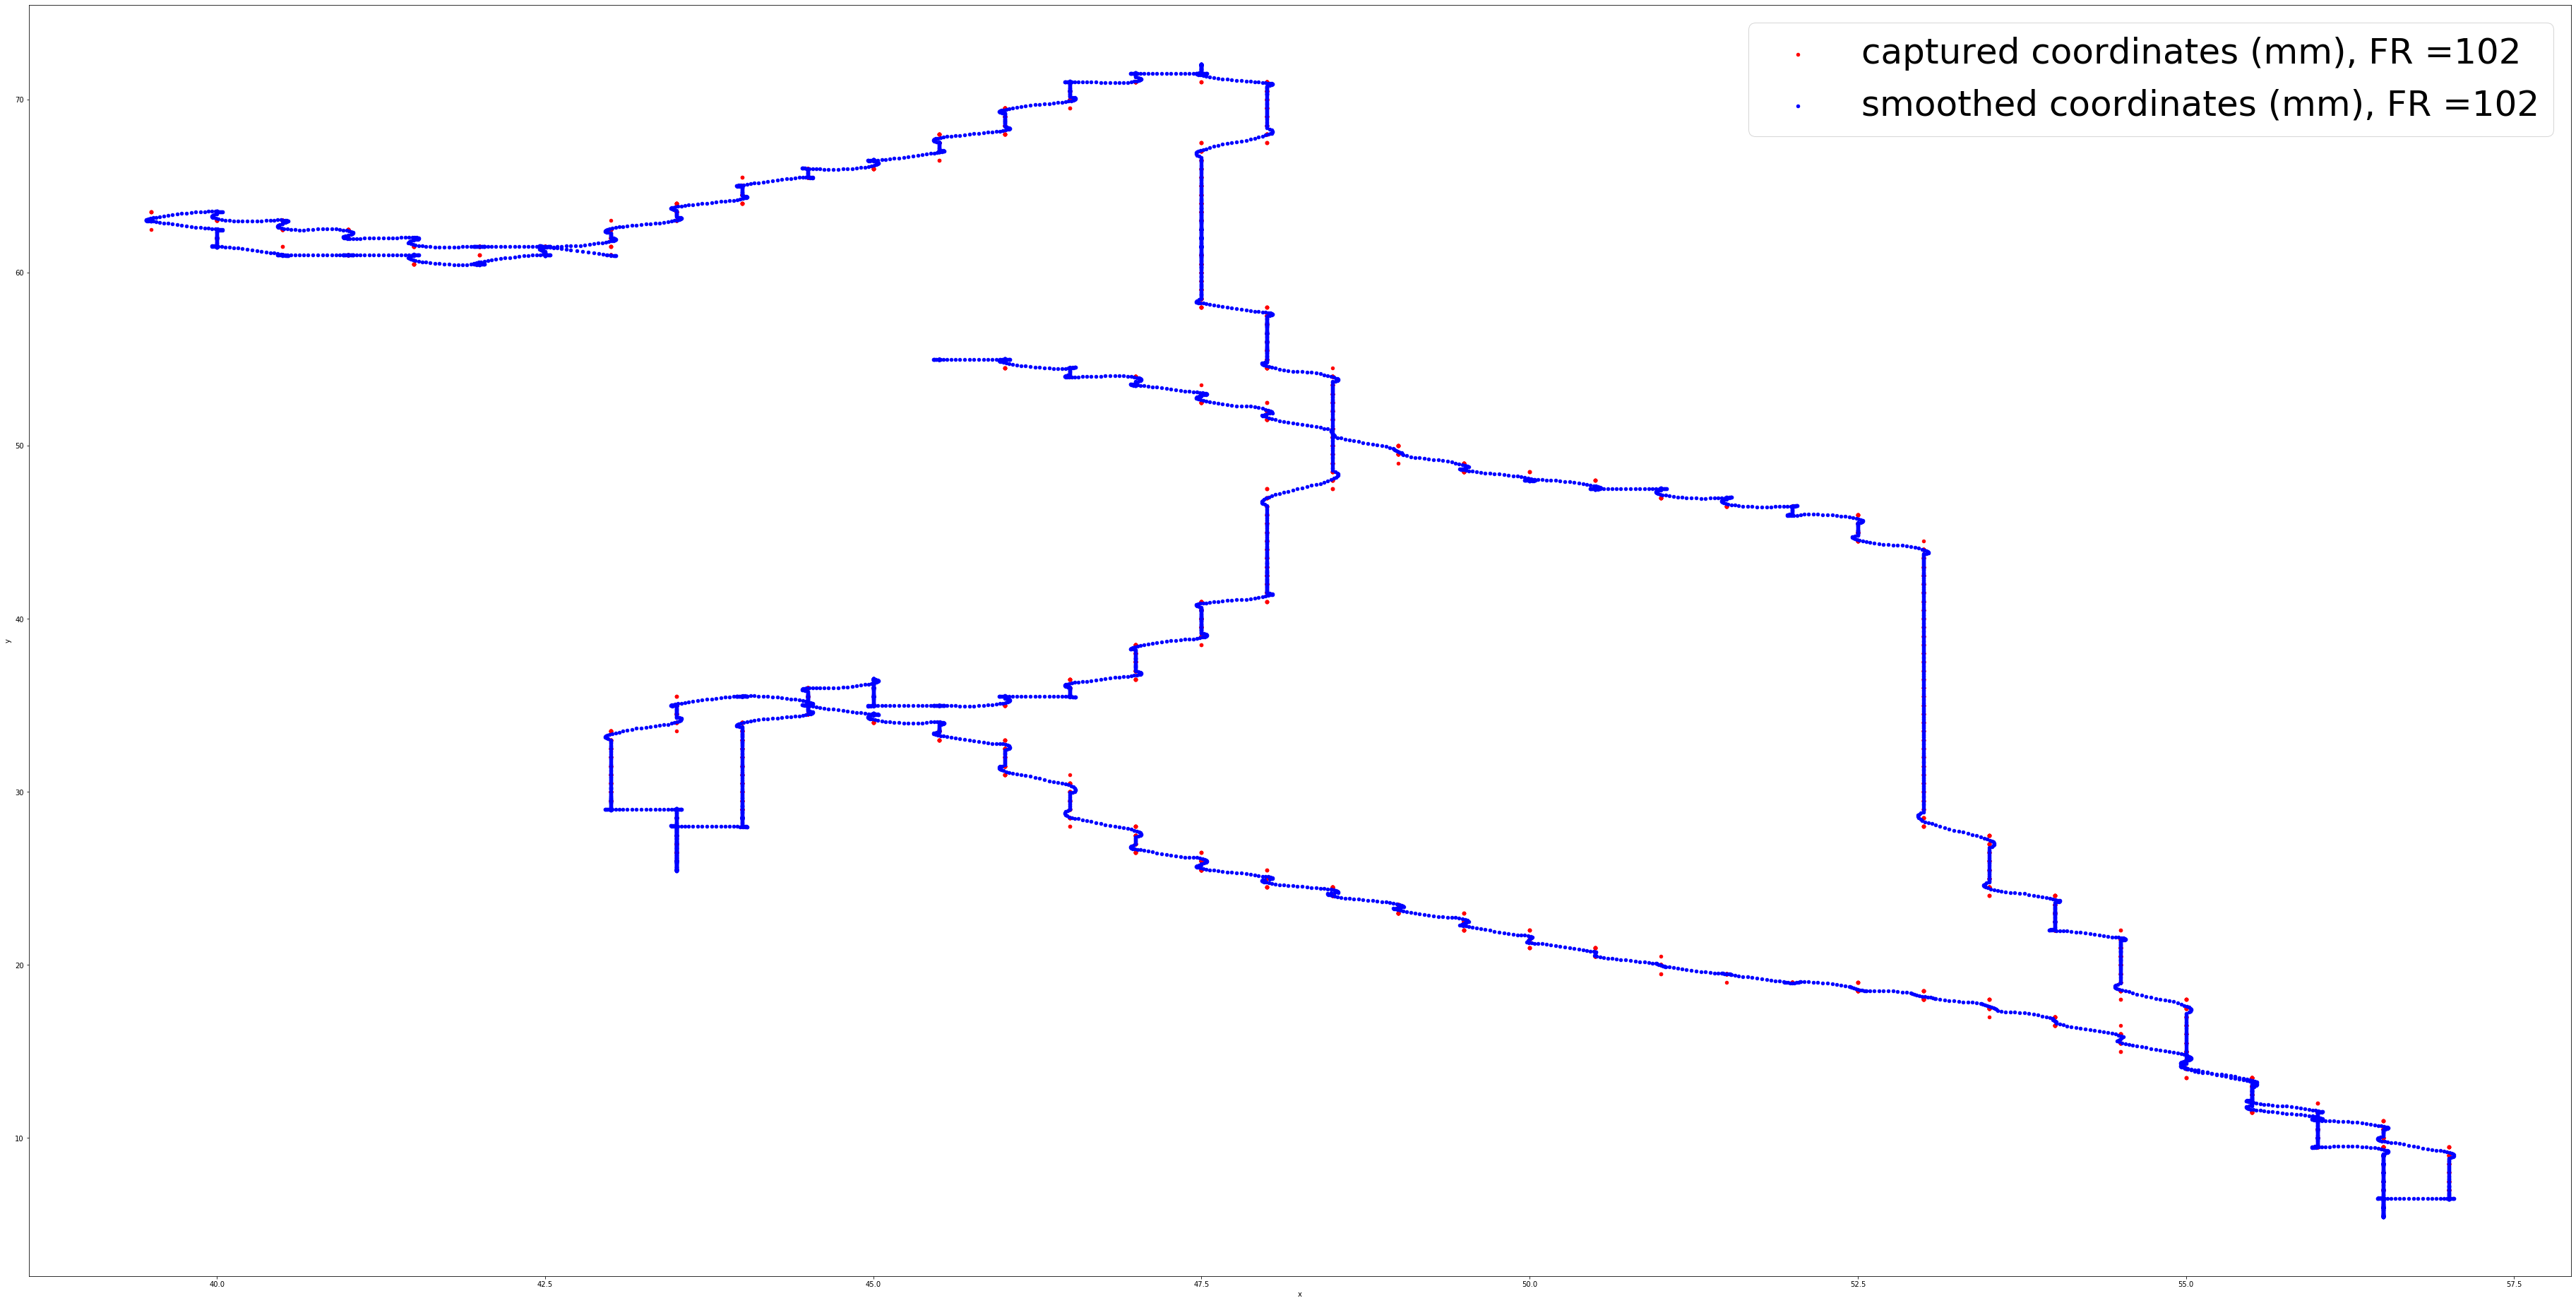

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

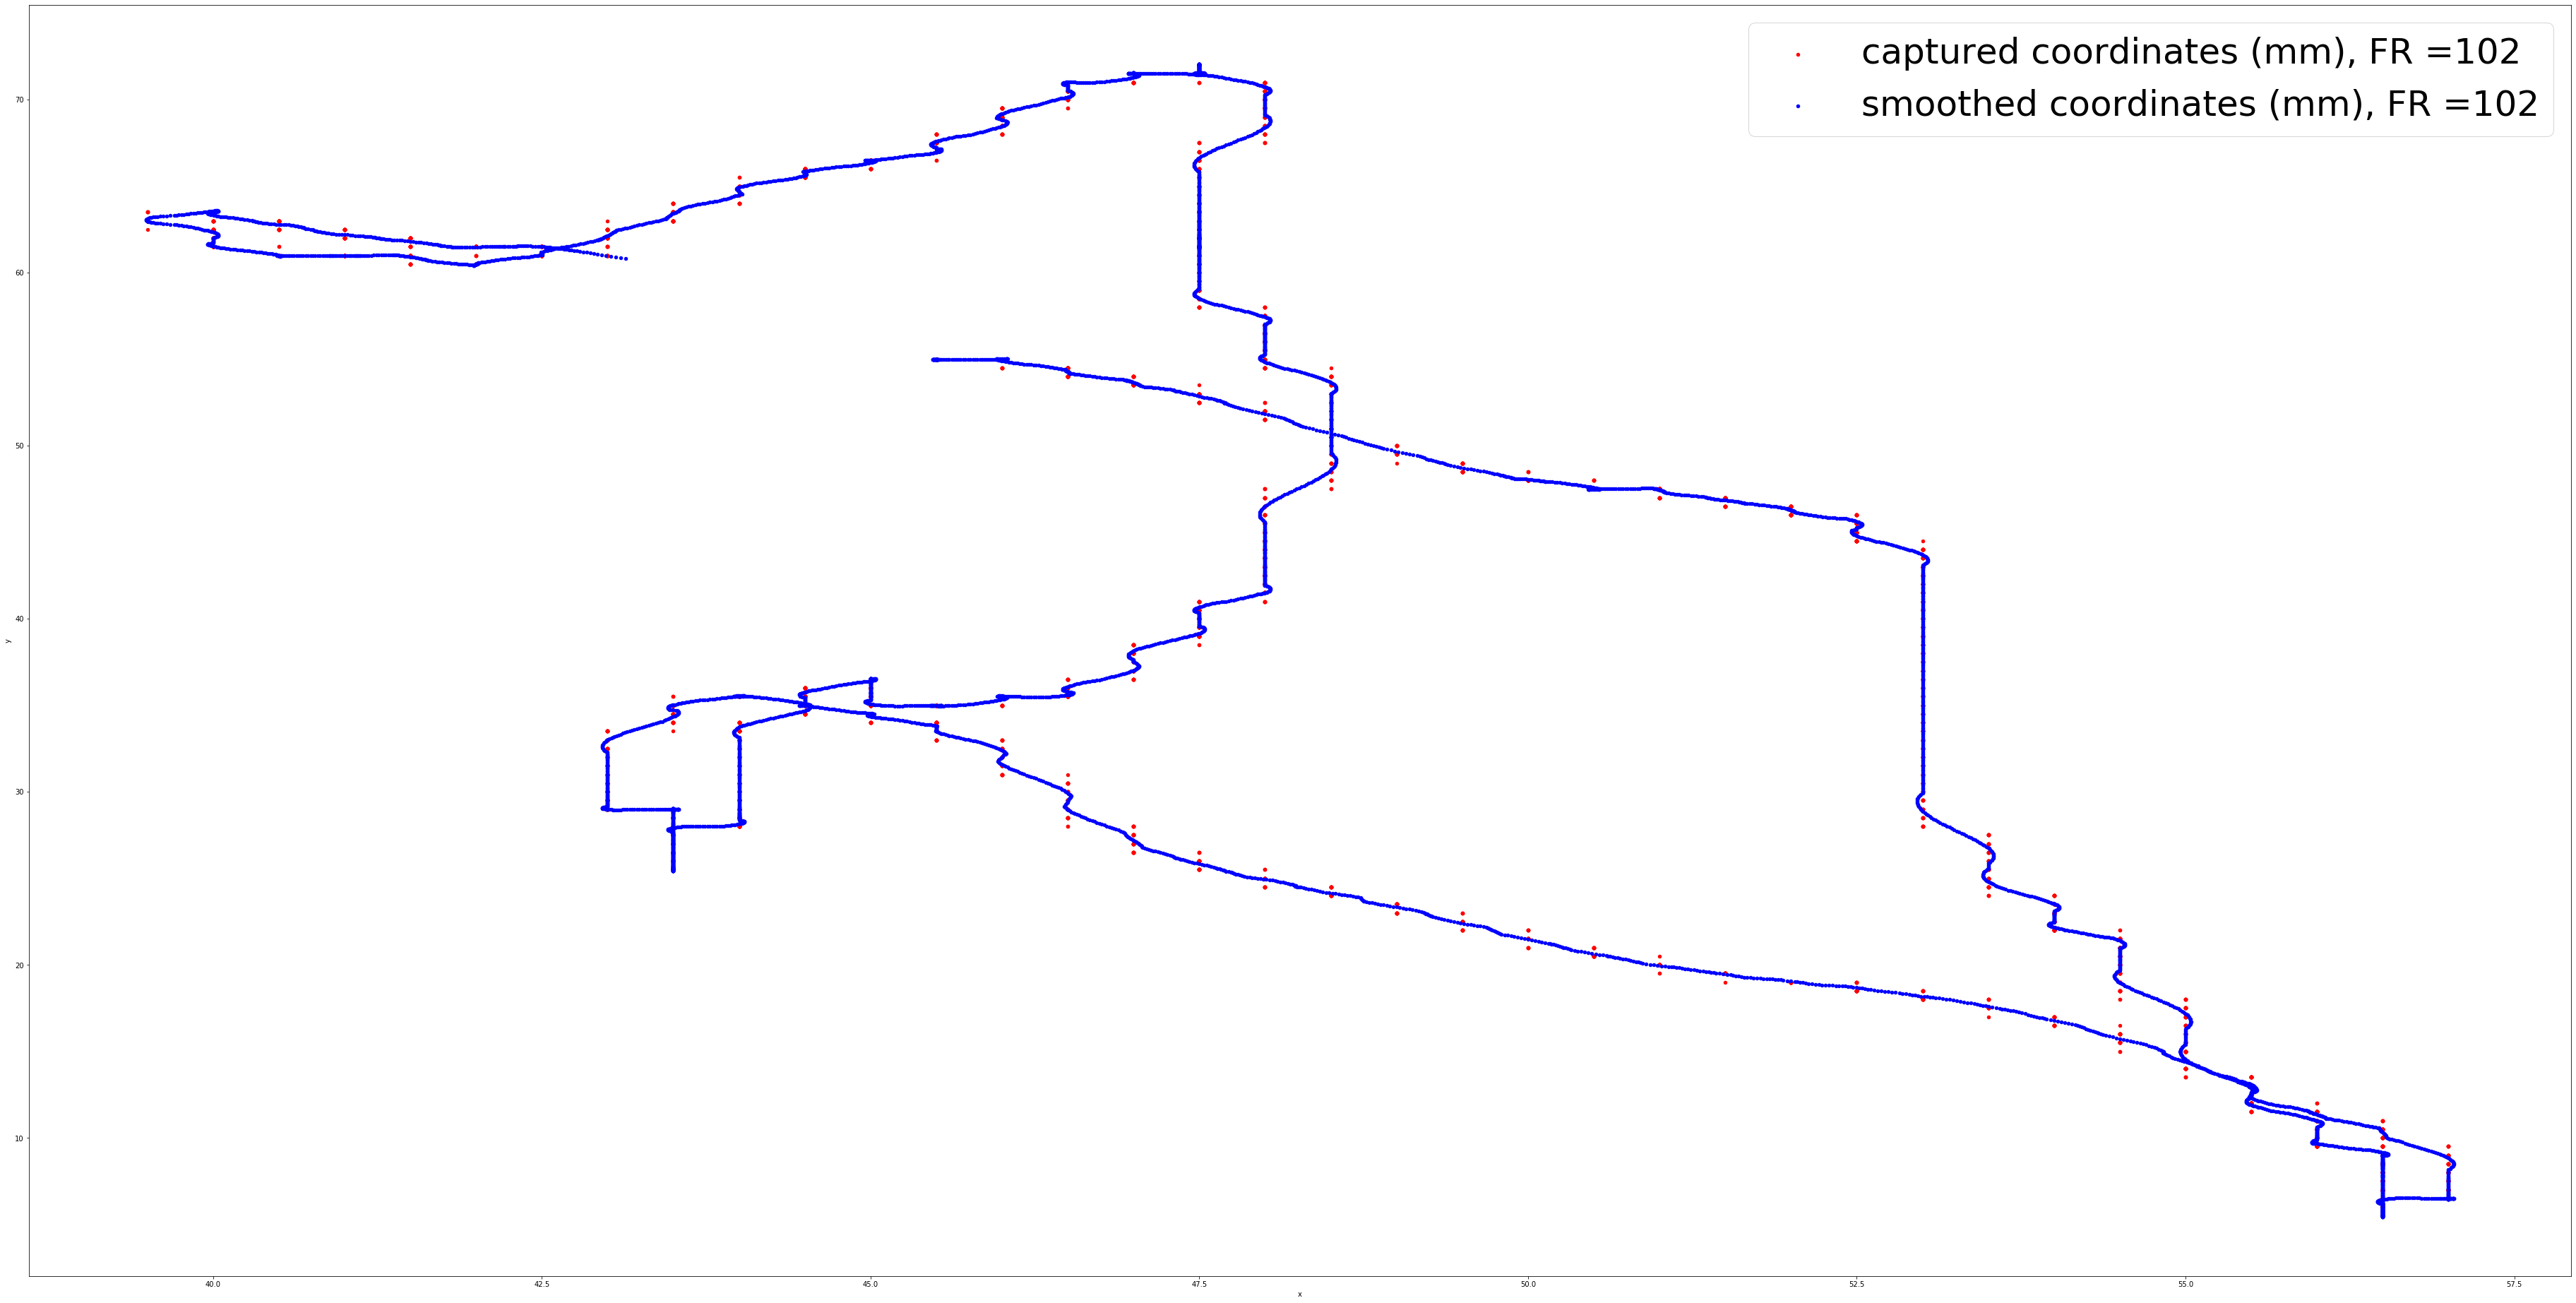

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

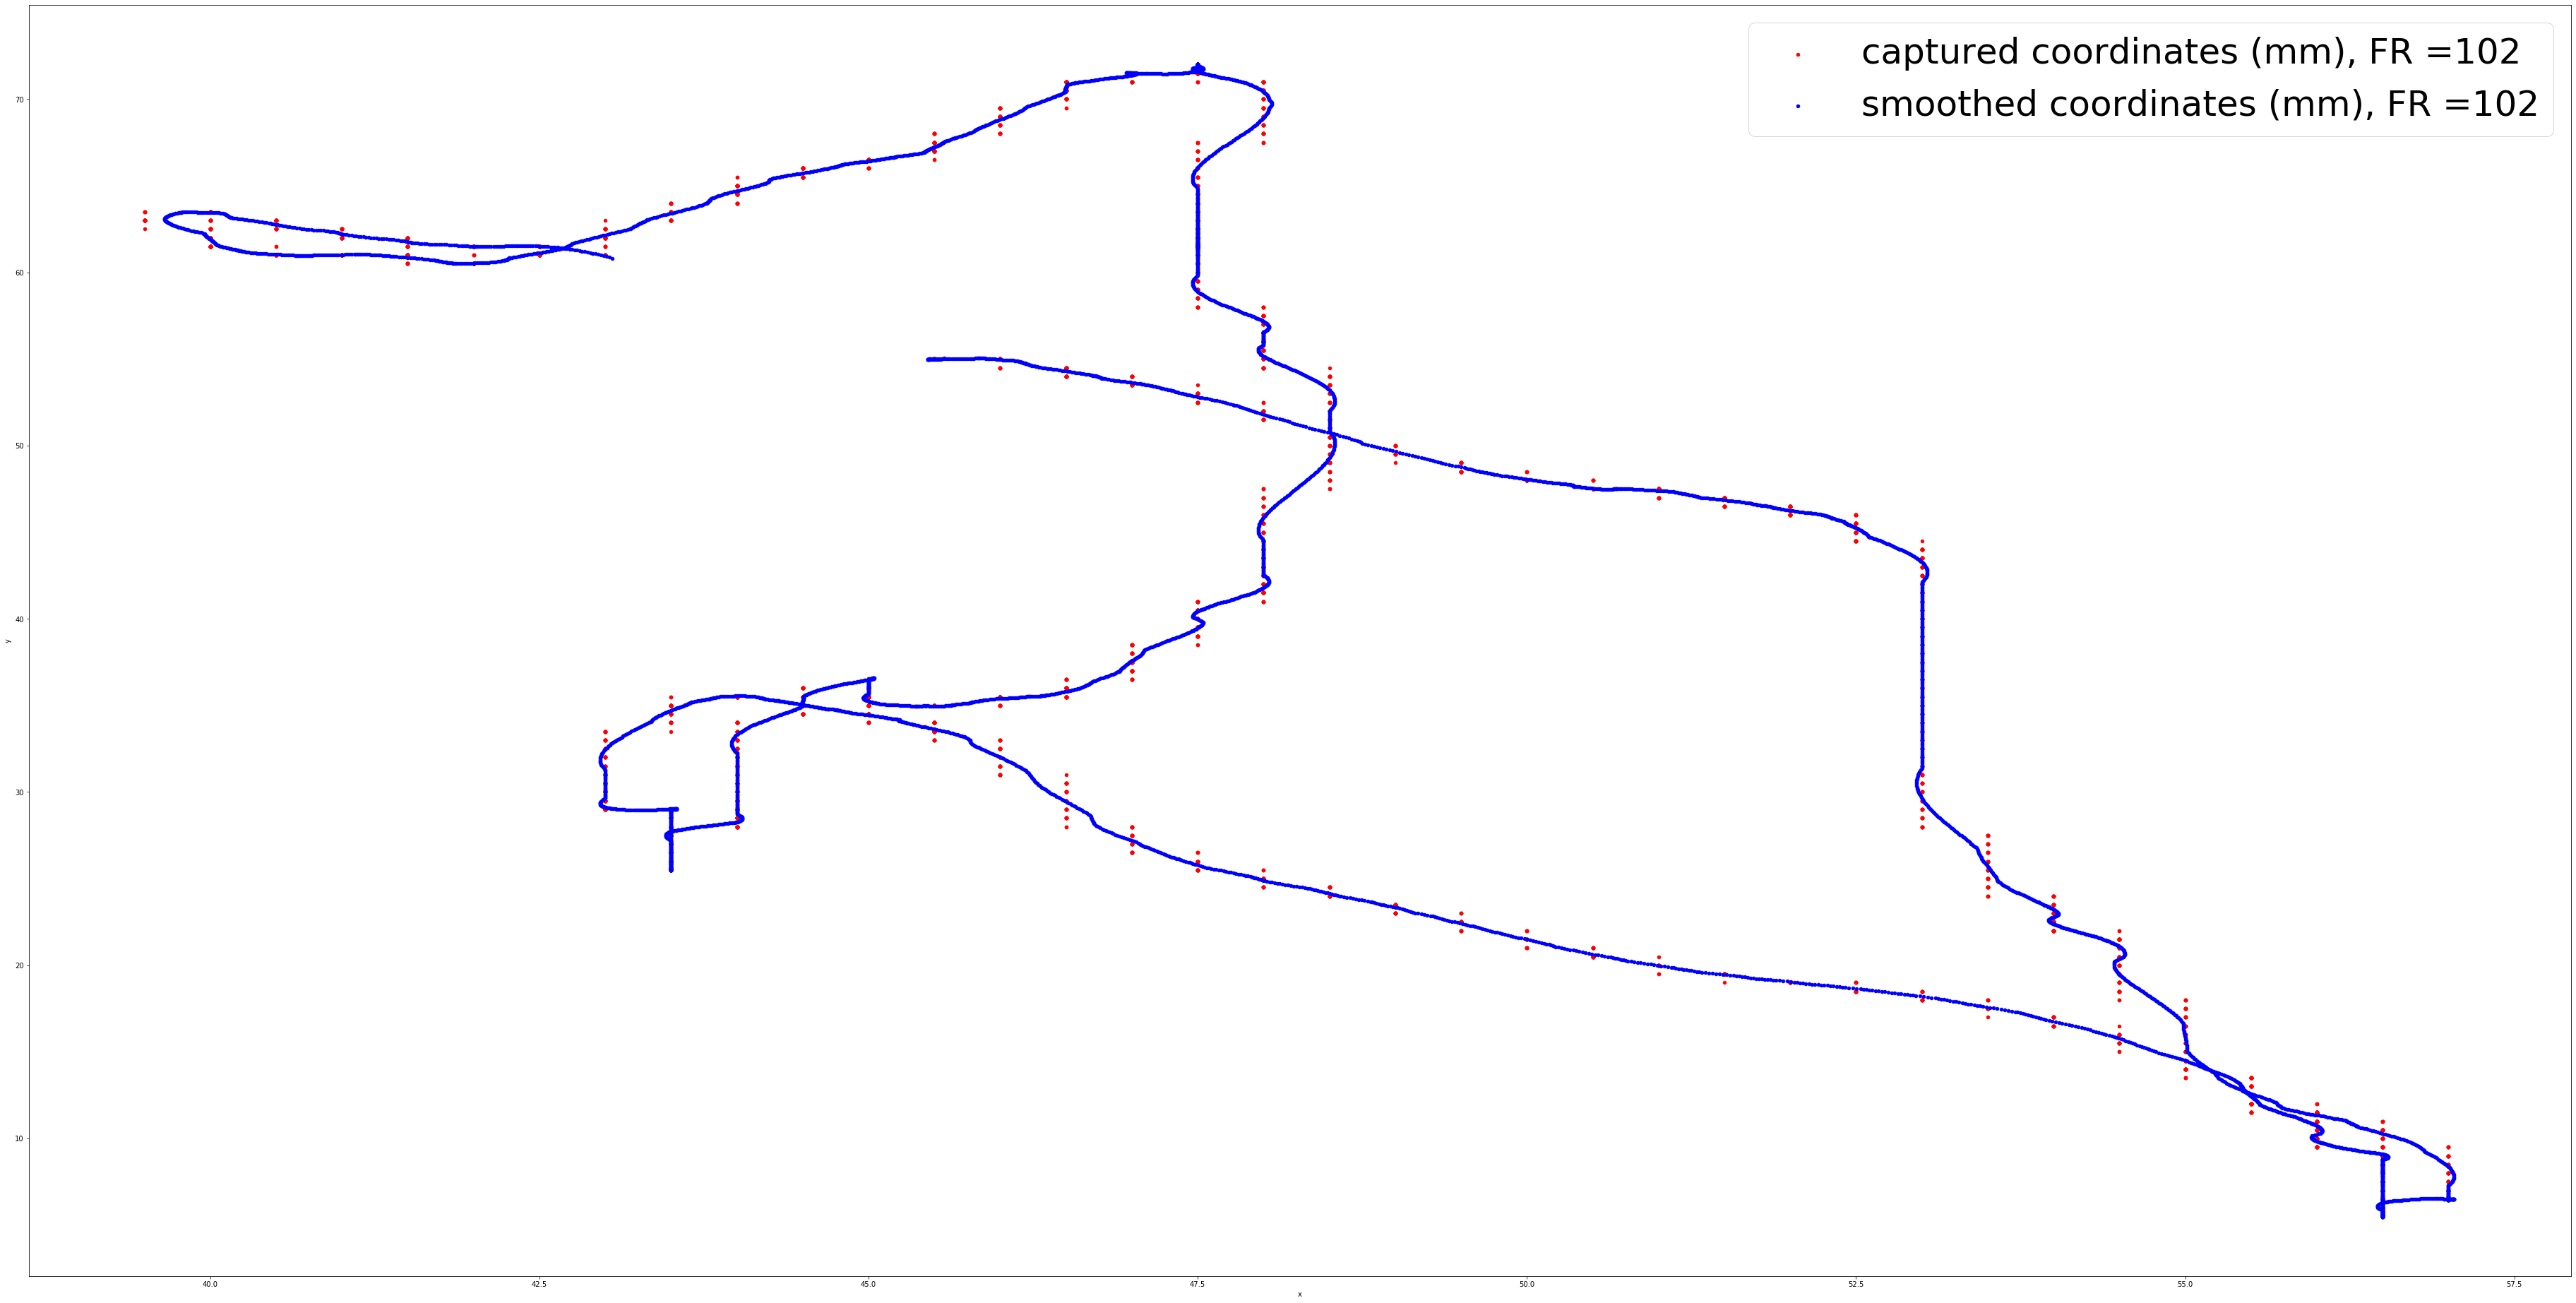

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

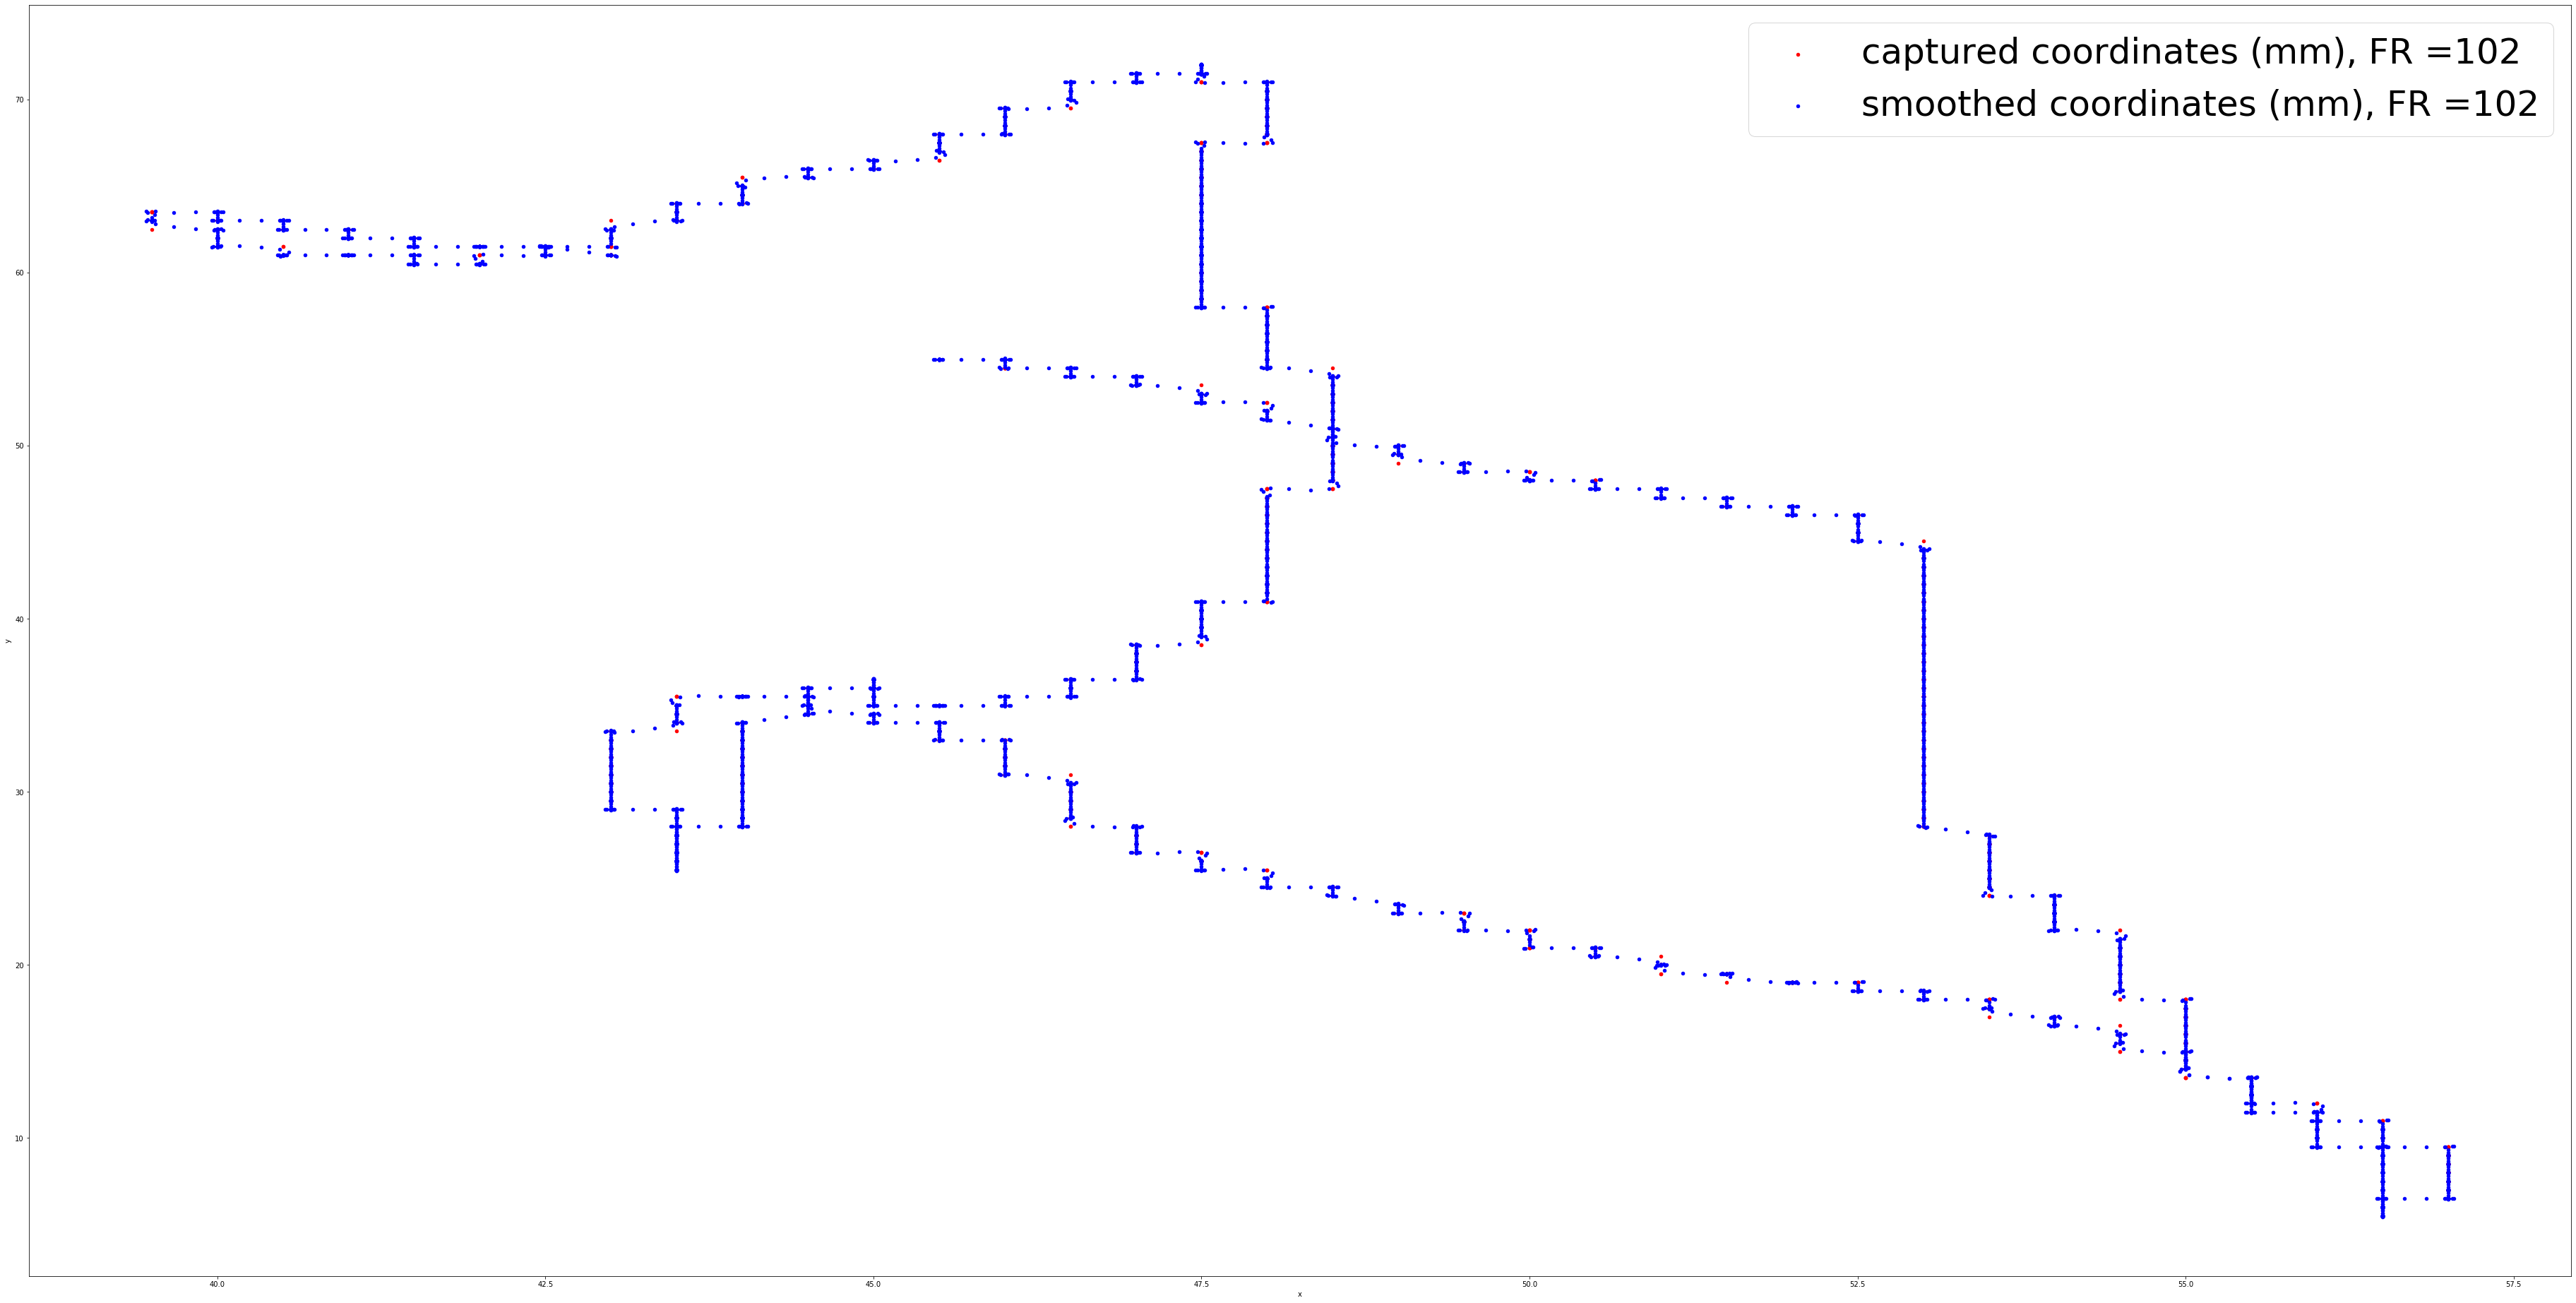

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

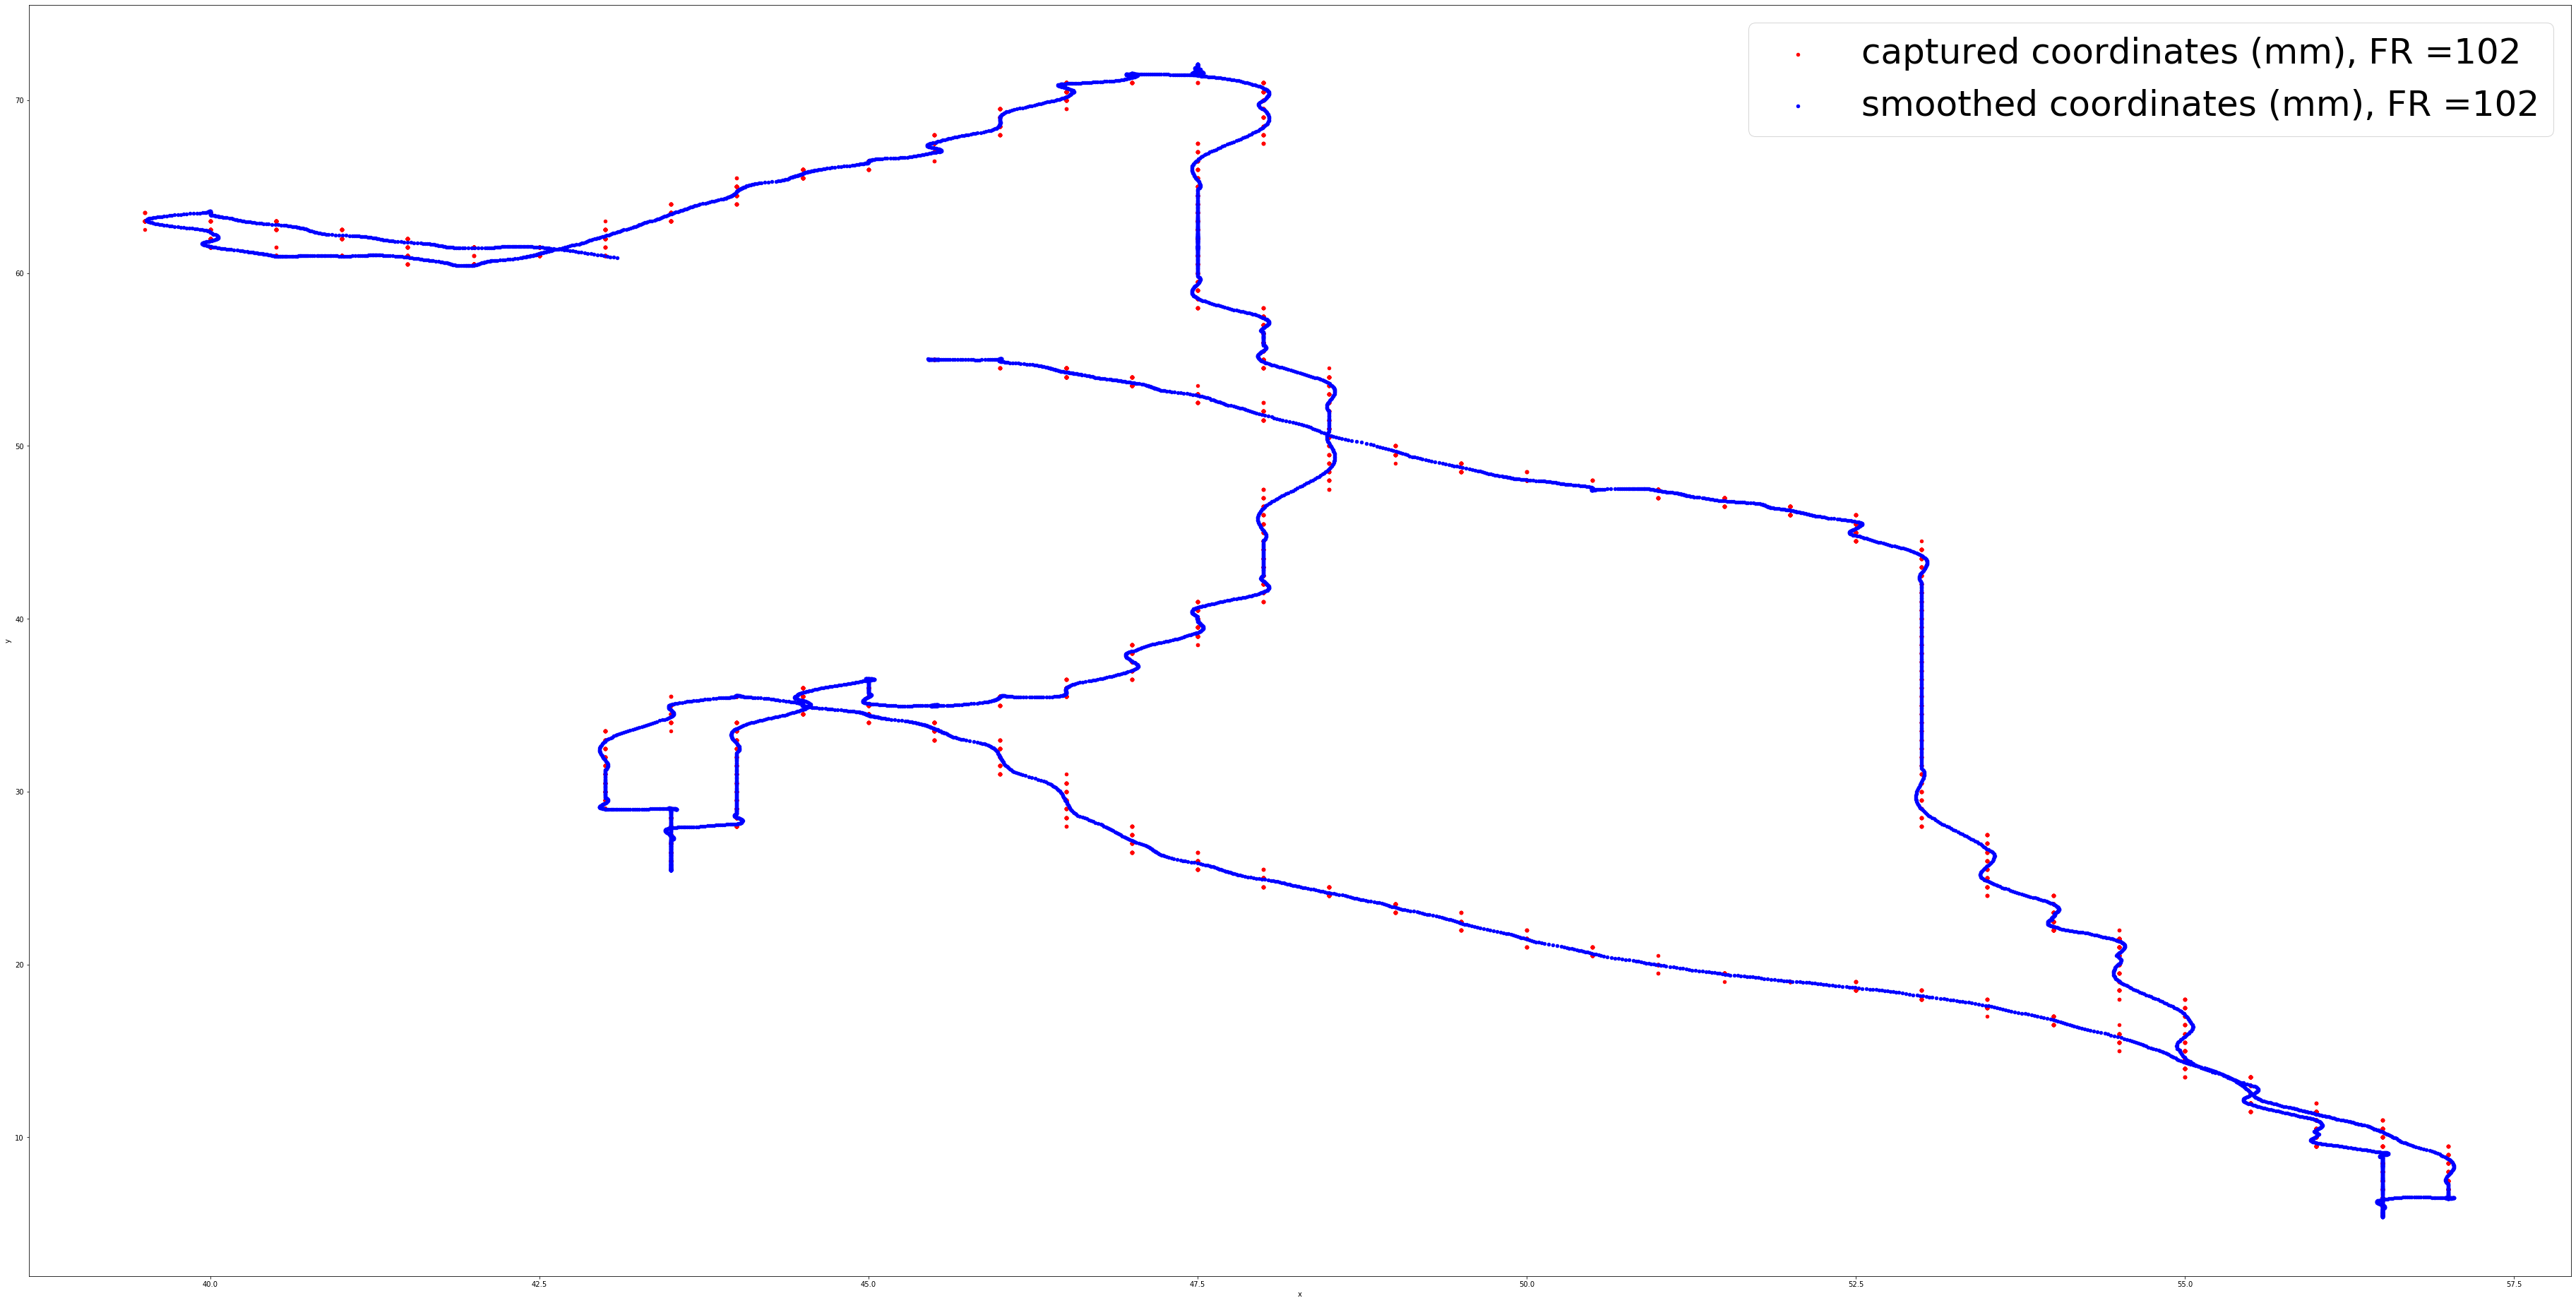

In [21]:
PlotCurve_const_window(34, 102, 3, 11)
PlotCurve_const_window(34, 102, 3, 30)
#for window length = 30 there are strange horizontal fluctuations in the bottom part
PlotCurve_const_window(34, 102, 3, 60)
PlotCurve_const_window(34, 102, 3, 100)
PlotCurve_const_window(34, 102, 5, 11)
PlotCurve_const_window(34, 102, 5, 100)

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

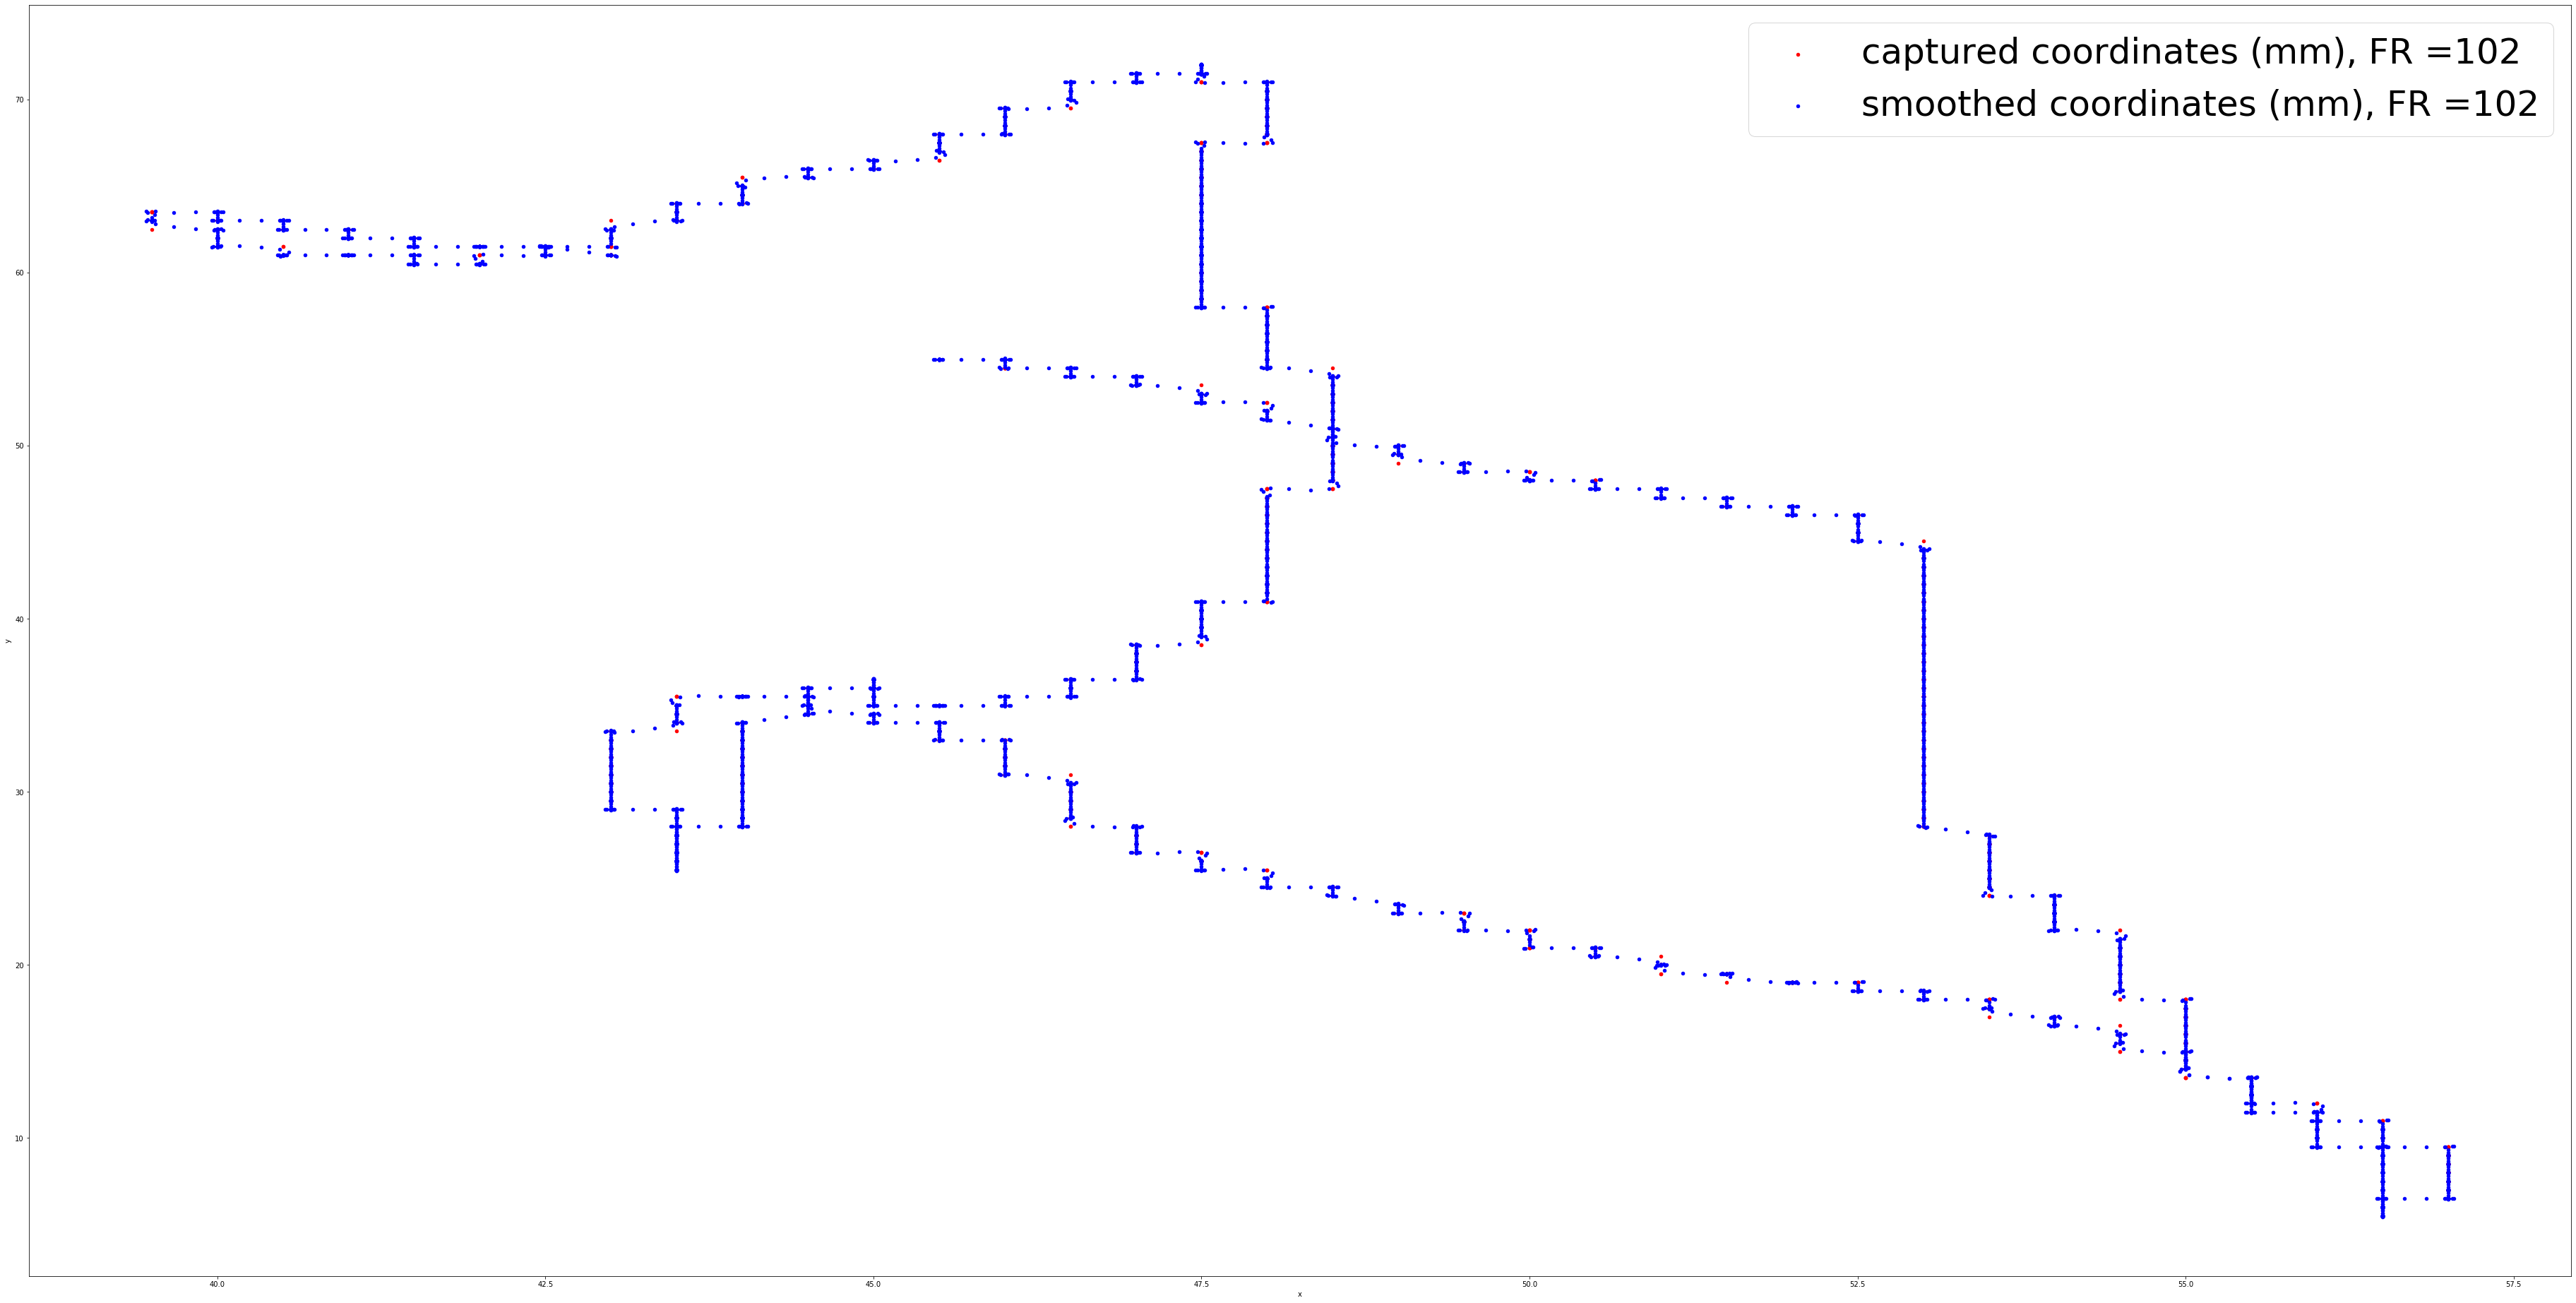

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

In [33]:
PlotCurve_const_window(34, 102, 5, 11)
#window length = 11
#e.g. line in the bottom for 40<x <55 and 5<y <30: "I"-shaped lines with dotted lines in between
#frames   point

#2987-3007: (48.5, 26)    first 15 points/middle 10 points: mapped to themselves, 
#last 5 points: a straight line x = 48.5 is fitted
#x is const
#y for frames 2997-3007: [26. 26. 26.  26. 26. 26. 26.02097902 25.96853147 25.95687646 26.02680653]
#linear interpolation but not really: increasing decreasing increasing
#how is the polynomial fitted when x is const


#3008-3022: (48.5, 26.5)

#for 3015-3025 x const, y: [26.5 26.5 26.5 26.52097902 26.46853147 26.45687646 26.52680653 26.66666667 26.83333333 26.97319347]
#again increasing decreasing increasing

#3023-3036: (48.5, 27)
#3037-3051: (48.5, 27.5)
#3052-3067: (48.5, 28)
#3068-3091: (48.5, 28.5)
#3092-3162: (48.5, 29)

#frames 3155-3170: here we should get a horizontal line
#[43.5        43.5        43.5        43.47902098 43.53146853 43.54312354
# 43.47319347 43.33333333 43.16666667 43.02680653 42.95687646 42.96853147
# 43.02097902 43.         43.        ]
#[29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]

#again decrease increase decrease



#3163-3197: (48, 29)
#3198 - : (48, 29.5)

#if we take a window length big enough horizontal lines will be fit more often


x, y, coords, d1, d2, V, C = getdata_const_window(34, 102, 5, 11)
coordsx = coords[0]
coordsy = coords[1]
print(coordsx[2997:3007])
print(coordsy[2997:3007])

print(coordsx[3015:3025])
print(coordsy[3015:3025])

print(coordsx[3155:3170])
print(coordsy[3155:3170])

In [ ]:
#BDD TESTS: how do FR vs BDD plot vary with order of polynomials
#take different kinds of curves: e.g. 28 and 34 have a lot of scatter, 38 and 45 are smooth


LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

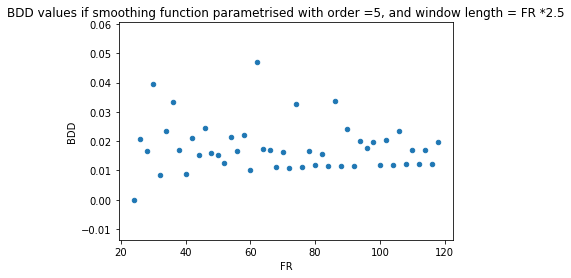

[0.0, 0.020674239350927784, 0.01669472407320635, 0.03954055505536012, 0.008376991804623233, 0.023524992319397486, 0.03327087567913091, 0.01714447160782639, 0.008762478647985609, 0.02111123925529842, 0.01543824900144171, 0.024358309614974902, 0.01588775352235459, 0.015174940857279207, 0.01256658457612273, 0.021292597849581346, 0.016501284794246958, 0.02200520683419868, 0.0100211504527195, 0.0469057996807411, 0.017353702382374794, 0.01693786897302002, 0.011060155183308829, 0.016307071056378998, 0.010947953018442784, 0.03262415627976858, 0.011255916153197544, 0.016814537115162367, 0.011903687103749045, 0.01572040317580862, 0.011446485352689393, 0.033747524553159436, 0.011532568641505528, 0.024130222897326473, 0.011619152327465233, 0.02019917065938711, 0.01760839872389738, 0.019641110979940254, 0.01179336589927564, 0.020537702543978957, 0.011802757711909107, 0.023571340086729346, 0.012337020161088959, 0.01697122980911439, 0.012276089166553447, 0.01696400755231167, 0.012277150210251503, 0.0

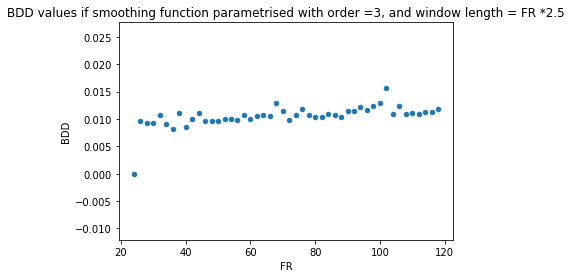

[0.0, 0.009642541229578801, 0.009332039776283604, 0.009352549961641168, 0.01070372378665458, 0.00916603865286101, 0.008129893672322487, 0.011156282437542823, 0.008593926310412385, 0.010013806431073285, 0.01103717068636257, 0.009659233178780502, 0.00969313602544879, 0.00971790030616549, 0.010088300110203754, 0.010073018280440852, 0.009732615621710818, 0.010709163428451414, 0.010069088794548571, 0.010555814344536922, 0.01079178841707406, 0.010494631239723374, 0.012874532418796665, 0.011517500774027615, 0.009884273303294831, 0.01073958024851623, 0.011875181126670204, 0.010749869147784752, 0.010366623628333512, 0.010418746321919579, 0.010908915644230575, 0.010775376410925163, 0.010310616515625584, 0.011485493079801196, 0.01141641898787659, 0.012187707479696969, 0.011604116653162405, 0.012435402711350352, 0.013002498337125284, 0.015578941449331711, 0.010967346059308178, 0.012335143682597674, 0.010950658898081398, 0.011023589988480204, 0.01096750872217599, 0.011271358374651404, 0.01124913382

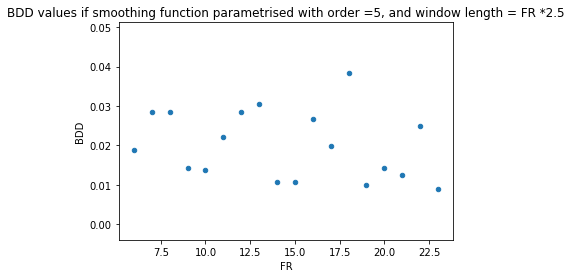

[0.018893610512955374, 0.02845498880139714, 0.02856051115069111, 0.014392233782420891, 0.013763375284617085, 0.02204480857541309, 0.028398207222290046, 0.030631707163698778, 0.01082949655438923, 0.010748470644686954, 0.026728552750501774, 0.0199550033926535, 0.03842719513481375, 0.009964198978094651, 0.014221625600815488, 0.012613708081010679, 0.024874297224293084, 0.00886508354786961]
LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal 

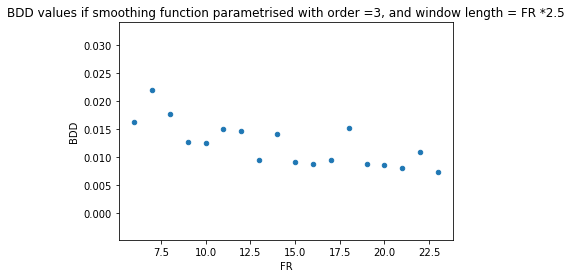

[0.016331952666580562, 0.021962338818067164, 0.017666922069702905, 0.012655104525619002, 0.012559006078656629, 0.01493115400175793, 0.014585891501042954, 0.009448452684477159, 0.014160857706164341, 0.009074691256574815, 0.008794221064766428, 0.009527135771482119, 0.015131364006594008, 0.008746249472813111, 0.008658557604138065, 0.008092728201609608, 0.010869331456785295, 0.007329212327508575]


In [42]:
computeBDDs(34, 'high', 5, 2.5)
computeBDDs(34, 'high', 3, 2.5)

#lower and consistent for ord = 3 (less variation, smooth curve)

computeBDDs(34, 'low', 5, 2.5)
computeBDDs(34, 'low', 3, 2.5)

LOG: Extracting coordinates for Animal CRV_33_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_33_TEST_00...
LOG: Extracting coordinates for Animal CRV_33_TEST_01...
LOG: Extracting coordinates for Animal CRV_33_TEST_02...
LOG: Extracting coordinates for Animal CRV_33_TEST_03...
LOG: Extracting coordinates for Animal CRV_33_TEST_04...
LOG: Extracting coordinates for Animal CRV_33_TEST_05...
LOG: Extracting coordinates for Animal CRV_33_TEST_06...
LOG: Extracting coordinates for Animal CRV_33_TEST_07...
LOG: Extracting coordinates for Animal CRV_33_TEST_08...
LOG: Extracting coordinates for Animal CRV_33_TEST_09...
LOG: Extracting coordinates for Animal CRV_33_TEST_10...
LOG: Extracting coordinates for Animal CRV_33_TEST_11...
LOG: Extracting coordinates for Animal CRV_33_TEST_12...
LOG: Extracting coordinates for Animal CRV_33_TEST_13...
LOG: Extracting coordinates for Animal CRV_33_TEST_14...
LOG: Extracting coordinates for Animal CRV_33_TEST_15...
LOG: Extracting coordinates f

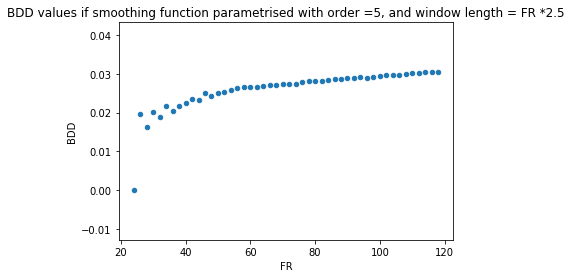

[0.0, 0.019517066116084582, 0.016197029909955567, 0.020149267982715737, 0.01872790860609241, 0.021687145125928353, 0.020348385506240345, 0.021577626494844813, 0.02237951603306014, 0.0234858436174816, 0.023294214634423983, 0.024936120102757194, 0.02417063655198056, 0.025055411872872788, 0.0253562916114863, 0.025690219681911042, 0.026206100963040255, 0.02652223443100171, 0.026485829049838074, 0.026644648464428964, 0.0268438588440194, 0.02707857724486381, 0.027121278607879683, 0.02737590169625796, 0.02733390345304079, 0.027486685931091395, 0.027784568998539004, 0.028200225447924627, 0.028187273087999773, 0.028214791295913574, 0.028359083697619584, 0.028585752858772143, 0.028548808641718562, 0.028820603310771242, 0.028864406167448696, 0.029094306641247077, 0.02888643428155286, 0.029239083030129193, 0.029421922360593253, 0.029600839394886263, 0.02959067627746757, 0.029787339028379062, 0.029852106305781605, 0.030129298127393976, 0.030314893641930272, 0.030355497891956833, 0.03033813009505564

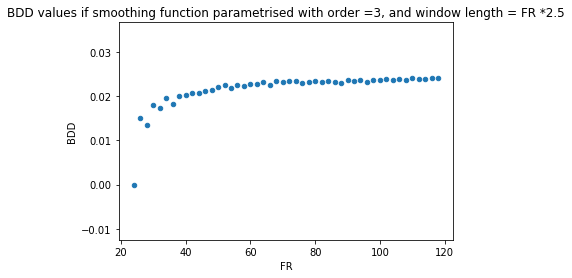

[0.0, 0.015008057240234685, 0.013518742575987733, 0.01792604690375732, 0.017358649910087433, 0.019514919039416215, 0.018244810844729707, 0.019962330347637797, 0.020179609412406357, 0.020765968990249756, 0.020747289125444456, 0.02128195599389798, 0.02134807607323315, 0.022052374339832235, 0.022602454852145164, 0.021973898954846166, 0.022518634874094532, 0.022364831208015325, 0.022787860549338644, 0.02283218795738241, 0.023218867532646396, 0.022653494375850954, 0.023349882484787737, 0.02315642200014137, 0.023532337496832194, 0.023403541709770773, 0.02305437390094659, 0.02325404716432422, 0.023528609730601103, 0.023143965392002357, 0.023347891130400804, 0.023149187965224485, 0.023095727677403005, 0.02367828179947903, 0.023481137517420175, 0.02359073470316521, 0.023295903383941472, 0.023732782100809178, 0.02369656075214738, 0.02379889058576193, 0.02366953206819943, 0.023825232622709712, 0.02376301864260136, 0.024089139029003077, 0.023984005634698626, 0.023890078792747325, 0.024070568833503

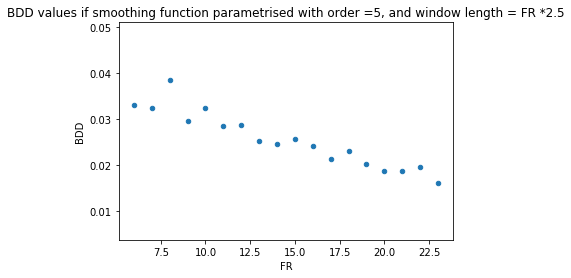

[0.03320288685792618, 0.032476512562867946, 0.03864345073111835, 0.029732289013395172, 0.03237159353674425, 0.02853030208057455, 0.028714055953954837, 0.025362375987686037, 0.02465057628961891, 0.025721798801221035, 0.02428823710464055, 0.021376032855902966, 0.023038327080124703, 0.020282174661392895, 0.01875288221202955, 0.01886136271659272, 0.019548557423768136, 0.016244109505161235]
LOG: Extracting coordinates for Animal CRV_33_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_33_TEST_00...
LOG: Extracting coordinates for Animal CRV_33_TEST_01...
LOG: Extracting coordinates for Animal CRV_33_TEST_02...
LOG: Extracting coordinates for Animal CRV_33_TEST_03...
LOG: Extracting coordinates for Animal CRV_33_TEST_04...
LOG: Extracting coordinates for Animal CRV_33_TEST_05...
LOG: Extracting coordinates for Animal CRV_33_TEST_06...
LOG: Extracting coordinates for Animal CRV_33_TEST_07...
LOG: Extracting coordinates for Animal CRV_33_TEST_08...
LOG: Extracting coordinates for Animal 

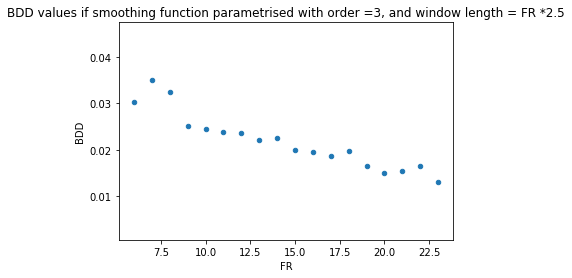

[0.030377936396677845, 0.035066627924818114, 0.032499223031584756, 0.02521385371966073, 0.02442946833401007, 0.023762543144101346, 0.023648378184659424, 0.02210091675808932, 0.022518407077586934, 0.019918287344350076, 0.01954881771000942, 0.01856716925575413, 0.019749507487721397, 0.01640062422108098, 0.015091381448272328, 0.015410499840870352, 0.01646134351928485, 0.012997537214510343]


In [43]:
computeBDDs(33, 'high', 5, 2.5)
computeBDDs(33, 'high', 3, 2.5)
#same for ord 3 and 5

computeBDDs(33, 'low', 5, 2.5)
computeBDDs(33, 'low', 3, 2.5)
#same

LOG: Extracting coordinates for Animal CRV_28_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_28_TEST_00...
LOG: Extracting coordinates for Animal CRV_28_TEST_01...
LOG: Extracting coordinates for Animal CRV_28_TEST_02...
LOG: Extracting coordinates for Animal CRV_28_TEST_03...
LOG: Extracting coordinates for Animal CRV_28_TEST_04...
LOG: Extracting coordinates for Animal CRV_28_TEST_05...
LOG: Extracting coordinates for Animal CRV_28_TEST_06...
LOG: Extracting coordinates for Animal CRV_28_TEST_07...
LOG: Extracting coordinates for Animal CRV_28_TEST_08...
LOG: Extracting coordinates for Animal CRV_28_TEST_09...
LOG: Extracting coordinates for Animal CRV_28_TEST_10...
LOG: Extracting coordinates for Animal CRV_28_TEST_11...
LOG: Extracting coordinates for Animal CRV_28_TEST_12...
LOG: Extracting coordinates for Animal CRV_28_TEST_13...
LOG: Extracting coordinates for Animal CRV_28_TEST_14...
LOG: Extracting coordinates for Animal CRV_28_TEST_15...
LOG: Extracting coordinates f

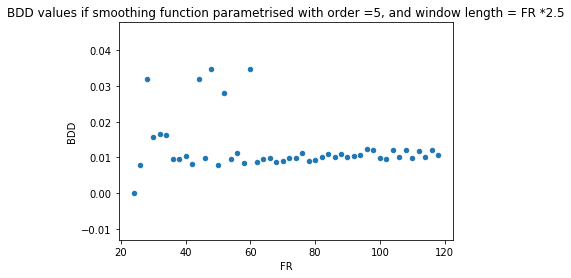

[0.0, 0.008010283113115618, 0.03183604120188452, 0.015656260626714883, 0.01644058341772409, 0.01629218423879317, 0.009546965162799735, 0.009654226059359559, 0.010446883933296083, 0.008108486183736526, 0.03181685454605241, 0.009858160227973839, 0.03474777868428708, 0.007979292470530802, 0.028118420171881073, 0.009495048836109906, 0.011358793935345954, 0.008460324883309757, 0.03467596266663085, 0.008698346800856788, 0.009640651201953732, 0.009956020639381866, 0.008789174449084999, 0.008864071904461281, 0.009752539514970909, 0.009914144086577375, 0.011202171317411285, 0.00906149266275281, 0.009350466726752283, 0.009997089089417894, 0.010985431234451833, 0.010153589352802628, 0.010983843647295983, 0.010220733304037707, 0.010465906252019505, 0.010565568111071347, 0.012343049359881307, 0.01219075780186892, 0.009863968350661103, 0.009550293305383432, 0.011999067867413853, 0.010195650275121251, 0.012033699881592435, 0.00989935552972272, 0.011800976847849821, 0.010029484148445691, 0.01201133042

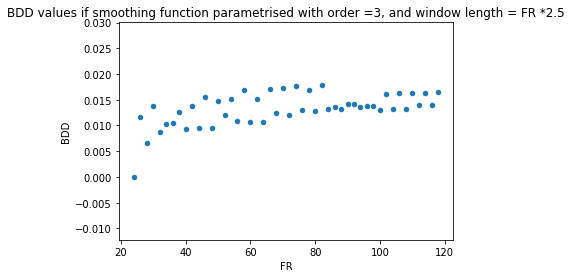

[0.0, 0.011591686701621895, 0.006552648375651483, 0.013765534825093977, 0.008746248685772458, 0.010361362330926532, 0.010428688452638673, 0.012567965113647505, 0.009266939826191005, 0.013758090591276554, 0.009483655161366027, 0.015588052896518689, 0.009425065447758037, 0.014792240159732753, 0.012114432953804734, 0.015238472826626144, 0.010941691308326893, 0.016897028777523485, 0.010725578692915298, 0.015052258380988804, 0.010742714957247977, 0.017026018144902885, 0.012460021250699739, 0.01720799332496309, 0.012082513597529368, 0.017691394735715227, 0.013065446345972662, 0.016985778548356777, 0.012903505317331759, 0.017824519380586205, 0.013108488259874393, 0.013630768438350585, 0.013145742930914304, 0.014239592986758476, 0.014136655669071997, 0.013551204847108308, 0.013725650906805014, 0.01370751801109056, 0.013001351519641512, 0.016084844563236306, 0.013248157548582095, 0.01633630820369854, 0.013205115025630444, 0.016217104059147707, 0.014045650233825584, 0.016383271024328076, 0.01403

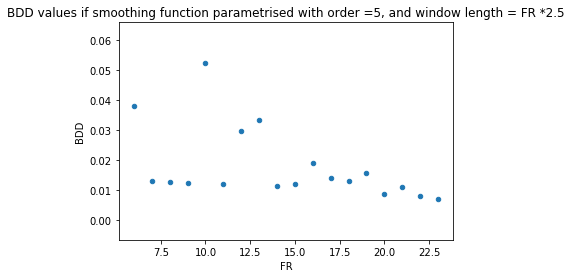

[0.03796730059785203, 0.013112518657585441, 0.012497337094330714, 0.012181405092012005, 0.0522341973292838, 0.012052333405792388, 0.02971975690416874, 0.033247556107237376, 0.011472431817164798, 0.011983662806251356, 0.018833352551706505, 0.014083156568541307, 0.012859023756543264, 0.015668665210696844, 0.008783549172415854, 0.011081612110166167, 0.008036570349041254, 0.006966583893456951]
LOG: Extracting coordinates for Animal CRV_28_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_28_TEST_00...
LOG: Extracting coordinates for Animal CRV_28_TEST_01...
LOG: Extracting coordinates for Animal CRV_28_TEST_02...
LOG: Extracting coordinates for Animal CRV_28_TEST_03...
LOG: Extracting coordinates for Animal CRV_28_TEST_04...
LOG: Extracting coordinates for Animal CRV_28_TEST_05...
LOG: Extracting coordinates for Animal CRV_28_TEST_06...
LOG: Extracting coordinates for Animal CRV_28_TEST_07...
LOG: Extracting coordinates for Animal CRV_28_TEST_08...
LOG: Extracting coordinates for Ani

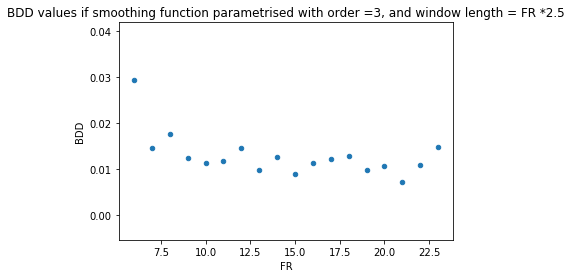

[0.029393672123905833, 0.01456804257480956, 0.01760682301887704, 0.012525238464841026, 0.011435715194008404, 0.011886159029245487, 0.014613628176016252, 0.009758326155221736, 0.012615627575535072, 0.009072425306035711, 0.011458140838676929, 0.012293222890917712, 0.012783519641753519, 0.009855306518397512, 0.010739464316606391, 0.007161328600441785, 0.0109809957458638, 0.014912981610846096]
LOG: Extracting coordinates for Animal CRV_28_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_28_TEST_00...
LOG: Extracting coordinates for Animal CRV_28_TEST_01...
LOG: Extracting coordinates for Animal CRV_28_TEST_02...
LOG: Extracting coordinates for Animal CRV_28_TEST_03...
LOG: Extracting coordinates for Animal CRV_28_TEST_04...
LOG: Extracting coordinates for Animal CRV_28_TEST_05...
LOG: Extracting coordinates for Animal CRV_28_TEST_06...
LOG: Extracting coordinates for Animal CRV_28_TEST_07...
LOG: Extracting coordinates for Animal CRV_28_TEST_08...
LOG: Extracting coordinates for Ani

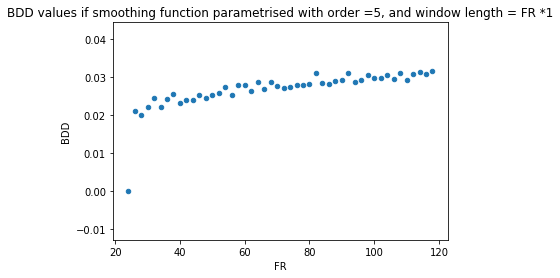

[0.0, 0.021091531601243677, 0.020061773997381648, 0.022023306279319695, 0.02433122420024129, 0.021953008694603236, 0.024120111580781558, 0.02560284753142683, 0.02308768399812584, 0.02382633151037505, 0.023878092951208952, 0.025320613863336613, 0.024424530306125382, 0.02510282000925092, 0.025651008845578905, 0.027206325898441103, 0.025242279961669414, 0.027921842602724446, 0.02796963317541307, 0.02634407813558345, 0.02863034916563069, 0.026812117447669166, 0.02861247919311036, 0.027633775362700442, 0.026947278650545636, 0.027374321408530432, 0.0279323266530251, 0.027756265587452856, 0.028077543769040113, 0.031056419115983103, 0.028475397685688113, 0.02804797047754302, 0.029022666830310902, 0.029171062462803623, 0.031132226289724844, 0.02871625082848323, 0.02924211502577715, 0.03049467220234204, 0.029597292341455396, 0.029822807670799485, 0.030371832713113882, 0.029553003382100138, 0.03109785984202831, 0.02914789742187683, 0.03083781421380557, 0.03125622204909091, 0.03063145068734882, 0.

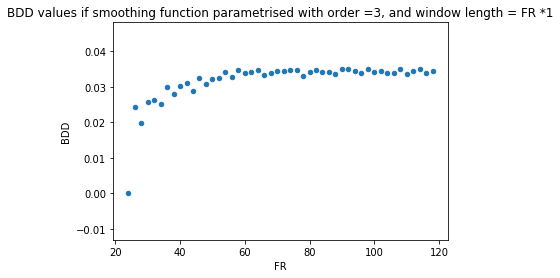

[0.0, 0.02419068127237157, 0.019920653359657856, 0.02578926866127329, 0.026332189707138215, 0.02527675862082362, 0.029952201997816494, 0.02809462530870187, 0.03032098904671401, 0.030965128587244272, 0.02882096911350692, 0.032423472583583905, 0.03082391655901456, 0.03226184916101553, 0.03232294809270266, 0.03422608744580765, 0.0327251495790373, 0.03469737979695475, 0.033919228834177376, 0.0341716144216077, 0.034734717128558745, 0.03325981638063626, 0.0338624411297129, 0.034475934106232, 0.03442177208545034, 0.03458832932767655, 0.034767616490908766, 0.03306348573789043, 0.03405523467674734, 0.03467396744490635, 0.03413218161987411, 0.034264331525232235, 0.033504606914921145, 0.034978442693863, 0.034881791766762954, 0.03441426624907768, 0.033772989039650446, 0.034975864729818375, 0.03408197404687996, 0.03435099586628536, 0.03393693941986993, 0.03400806888004583, 0.03505245302259555, 0.03366379996283188, 0.03436648627679194, 0.03503819758611297, 0.03396729130854726, 0.03433416047539592]


In [48]:
computeBDDs(28, 'high', 5, 2.5)
computeBDDs(28, 'high', 3, 2.5)
#overall shape similar, but for ord = 3 there are no outliers (unlike for ord 5)

computeBDDs(28, 'low', 5, 2.5)
computeBDDs(28, 'low', 3, 2.5)
#same as above, slightly higher but no outliers

computeBDDs(28, 'high', 5, 1)
computeBDDs(28, 'high', 3, 1)

LOG: Extracting coordinates for Animal CRV_38_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_38_TEST_00...
LOG: Extracting coordinates for Animal CRV_38_TEST_01...
LOG: Extracting coordinates for Animal CRV_38_TEST_02...
LOG: Extracting coordinates for Animal CRV_38_TEST_03...
LOG: Extracting coordinates for Animal CRV_38_TEST_04...
LOG: Extracting coordinates for Animal CRV_38_TEST_05...
LOG: Extracting coordinates for Animal CRV_38_TEST_06...
LOG: Extracting coordinates for Animal CRV_38_TEST_07...
LOG: Extracting coordinates for Animal CRV_38_TEST_08...
LOG: Extracting coordinates for Animal CRV_38_TEST_09...
LOG: Extracting coordinates for Animal CRV_38_TEST_10...
LOG: Extracting coordinates for Animal CRV_38_TEST_11...
LOG: Extracting coordinates for Animal CRV_38_TEST_12...
LOG: Extracting coordinates for Animal CRV_38_TEST_13...
LOG: Extracting coordinates for Animal CRV_38_TEST_14...
LOG: Extracting coordinates for Animal CRV_38_TEST_15...
LOG: Extracting coordinates f

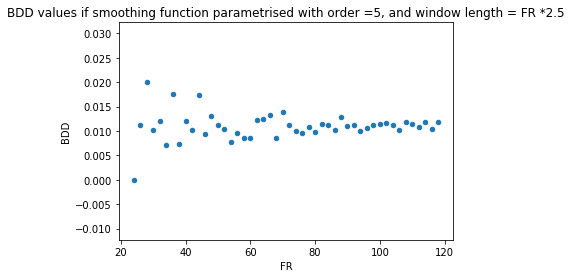

[0.0, 0.011192819338019203, 0.019955253638707513, 0.010133509486835673, 0.012091986533625053, 0.00716231330588001, 0.017627198119593786, 0.007244349006282267, 0.012008829151720028, 0.010127453816393564, 0.017279861340577386, 0.009399876759779385, 0.01312121185503441, 0.011317495866366656, 0.010432814443580659, 0.007768859816732068, 0.00958609684021995, 0.008611324228443127, 0.008500099901253092, 0.012155091526510424, 0.012371239195582157, 0.01325703506806996, 0.008604087279014452, 0.013892102268452215, 0.011242938366531135, 0.010027555267848693, 0.009616568986893356, 0.010814621663275842, 0.00974007409112883, 0.011434503366943625, 0.011227626832559396, 0.01015008811584344, 0.0128047152854363, 0.010940164392253813, 0.011207308274385373, 0.010025481788632098, 0.010630710861465307, 0.011305356812518081, 0.01139220844194393, 0.011650945869568167, 0.011267049038498735, 0.010117271215802838, 0.01190147991957009, 0.011509579222272505, 0.01090288018819969, 0.011932295583654934, 0.0104228924208

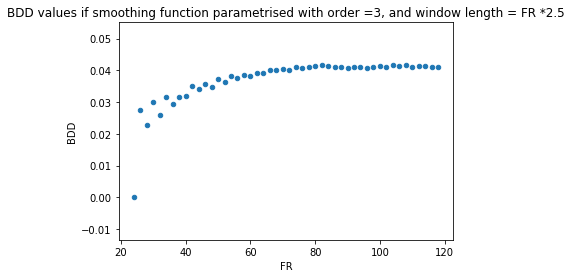

[0.0, 0.027466701025922833, 0.022776255311505192, 0.030046476678506046, 0.025927055506227214, 0.03161261407344843, 0.0294052967329551, 0.031649541428186274, 0.03203289460254361, 0.03490081493565764, 0.034042890917238736, 0.035835604507295254, 0.03459295319324262, 0.03712181673248061, 0.036389560192147986, 0.0380595718499044, 0.03751760285352471, 0.038382322757135524, 0.0383196566961132, 0.03917687449944717, 0.03899946652679171, 0.0399700047708592, 0.03999163887551151, 0.0403784292536243, 0.03996082527022689, 0.04094361510111882, 0.040702980142601014, 0.04098232315788765, 0.04124455241641805, 0.04152679876526285, 0.041338743036088435, 0.040893588175658226, 0.04095014596979369, 0.04076314879721936, 0.04114683514661919, 0.04099717279976151, 0.04083690498894134, 0.041168767885171376, 0.0412542447433735, 0.04111563225059998, 0.04170663184263021, 0.04148595031734973, 0.041626463141750926, 0.04100759960881968, 0.04149618475665712, 0.04120655883441323, 0.04117912686562506, 0.04116406446705541]

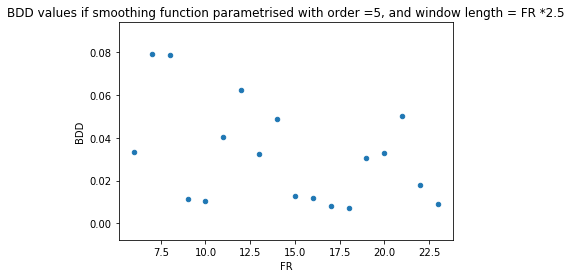

[0.0335027637400658, 0.07914909443790438, 0.07877492887273238, 0.011651518547207645, 0.010480056976375761, 0.04059928540914289, 0.06235990126752421, 0.03242647035492927, 0.04907449865408129, 0.012711806980732626, 0.011987217783567981, 0.00827751270383881, 0.007238962998560314, 0.030565224274777304, 0.03316052349608964, 0.05041256524364313, 0.01777919750570788, 0.009121646117398999]
LOG: Extracting coordinates for Animal CRV_38_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_38_TEST_00...
LOG: Extracting coordinates for Animal CRV_38_TEST_01...
LOG: Extracting coordinates for Animal CRV_38_TEST_02...
LOG: Extracting coordinates for Animal CRV_38_TEST_03...
LOG: Extracting coordinates for Animal CRV_38_TEST_04...
LOG: Extracting coordinates for Animal CRV_38_TEST_05...
LOG: Extracting coordinates for Animal CRV_38_TEST_06...
LOG: Extracting coordinates for Animal CRV_38_TEST_07...
LOG: Extracting coordinates for Animal CRV_38_TEST_08...
LOG: Extracting coordinates for Animal CRV_

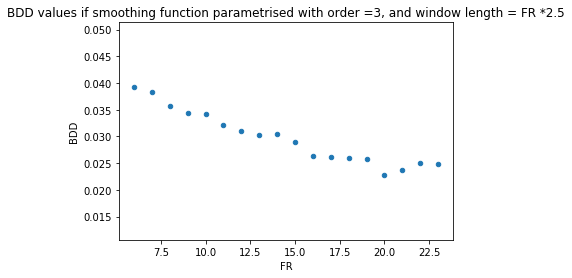

[0.039221913858721605, 0.03835629049711518, 0.03563544196603206, 0.03444831638451722, 0.03419449237022056, 0.03221381717736689, 0.03101202517326957, 0.030351632307864876, 0.030491873644861646, 0.028879078961960368, 0.02629123051446306, 0.026130932697781297, 0.0259855245806606, 0.02586665035760826, 0.02279753774326842, 0.023786253678280873, 0.025067048646020367, 0.024792040552443828]


In [45]:
computeBDDs(38, 'high', 5, 2.5)
computeBDDs(38, 'high', 3, 2.5)

#for ord 3 the curve is smoother and converges but BDD is higher 0.03 > 0.01

computeBDDs(38, 'low', 5, 2.5)
computeBDDs(38, 'low', 3, 2.5)
#again smoother for ord 3

LOG: Extracting coordinates for Animal CRV_45_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_45_TEST_00...
LOG: Extracting coordinates for Animal CRV_45_TEST_01...
LOG: Extracting coordinates for Animal CRV_45_TEST_02...
LOG: Extracting coordinates for Animal CRV_45_TEST_03...
LOG: Extracting coordinates for Animal CRV_45_TEST_04...
LOG: Extracting coordinates for Animal CRV_45_TEST_05...
LOG: Extracting coordinates for Animal CRV_45_TEST_06...
LOG: Extracting coordinates for Animal CRV_45_TEST_07...
LOG: Extracting coordinates for Animal CRV_45_TEST_08...
LOG: Extracting coordinates for Animal CRV_45_TEST_09...
LOG: Extracting coordinates for Animal CRV_45_TEST_10...
LOG: Extracting coordinates for Animal CRV_45_TEST_11...
LOG: Extracting coordinates for Animal CRV_45_TEST_12...
LOG: Extracting coordinates for Animal CRV_45_TEST_13...
LOG: Extracting coordinates for Animal CRV_45_TEST_14...
LOG: Extracting coordinates for Animal CRV_45_TEST_15...
LOG: Extracting coordinates f

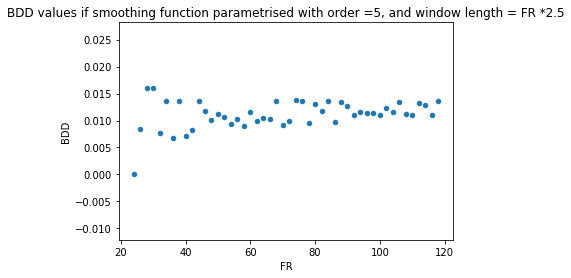

[0.0, 0.008423281359697521, 0.016081129649676215, 0.01595579635117208, 0.007733441413364013, 0.013608882392422856, 0.006697462896420876, 0.01364915761459547, 0.007129924098673452, 0.008195110519367242, 0.013660427123241486, 0.011704206653001023, 0.010121146818855979, 0.011237631266907307, 0.010671828488677475, 0.00929722732676201, 0.010232418855604336, 0.008936081924287227, 0.011494450990838559, 0.00985907999009446, 0.010432145362423786, 0.010353645240969366, 0.013665433264744498, 0.009087485384728736, 0.009842682111143902, 0.013800852251335429, 0.013633094093666667, 0.00948281160191449, 0.01306010328347566, 0.011719063614162811, 0.013593268464021134, 0.00976148143133251, 0.013371271778655698, 0.012748979592273708, 0.011037152412619275, 0.011622018617841148, 0.011306626902965715, 0.011474766532535905, 0.011099449544584842, 0.012294626254847034, 0.011537986800109992, 0.013491145582933716, 0.011290347522186423, 0.010994478252663373, 0.01333001380565792, 0.012874383293328137, 0.0109623926

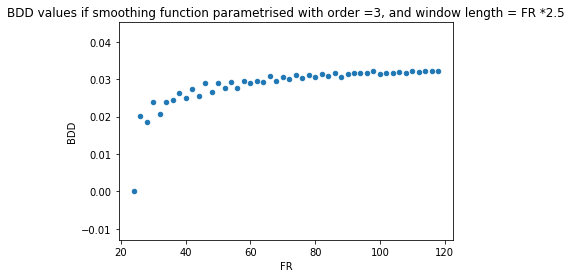

[0.0, 0.020187892495984617, 0.018507959149271502, 0.024022655660041598, 0.02064784230088692, 0.02392595161878646, 0.02433779778782321, 0.026450149996052795, 0.025083633402618603, 0.027279361284571185, 0.025460785834164744, 0.02903481085974953, 0.02649553080364147, 0.028922977843569328, 0.02761283542421684, 0.029265142786911898, 0.027743981996856446, 0.029462231746937545, 0.029128006372936832, 0.02958146752845748, 0.029161269455548252, 0.030746172799309187, 0.029497747156830456, 0.030674282604161603, 0.030174937010261194, 0.031178475225577255, 0.030387069538033835, 0.03107915169463199, 0.03047635011644002, 0.03143220444749084, 0.030920151522538842, 0.03162145582126678, 0.03072448582893518, 0.031405187751339776, 0.031568341774787394, 0.03164603052323519, 0.031541173470738634, 0.03215874431931396, 0.031420753658065625, 0.03177833402471879, 0.03169331009784363, 0.031816715824839484, 0.03170702199792433, 0.03217218490778553, 0.03181867388773905, 0.03228125497752134, 0.03213629389258731, 0.0

In [40]:
computeBDDs(45, 'high', 5, 2.5)
computeBDDs(45, 'high', 3, 2.5)
#same as above: for ord 3 the curve is smoother but BDD higher

LOG: Extracting coordinates for Animal CRV_44_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_44_TEST_00...
LOG: Extracting coordinates for Animal CRV_44_TEST_01...
LOG: Extracting coordinates for Animal CRV_44_TEST_02...
LOG: Extracting coordinates for Animal CRV_44_TEST_03...
LOG: Extracting coordinates for Animal CRV_44_TEST_04...
LOG: Extracting coordinates for Animal CRV_44_TEST_05...
LOG: Extracting coordinates for Animal CRV_44_TEST_06...
LOG: Extracting coordinates for Animal CRV_44_TEST_07...
LOG: Extracting coordinates for Animal CRV_44_TEST_08...
LOG: Extracting coordinates for Animal CRV_44_TEST_09...
LOG: Extracting coordinates for Animal CRV_44_TEST_10...
LOG: Extracting coordinates for Animal CRV_44_TEST_11...
LOG: Extracting coordinates for Animal CRV_44_TEST_12...
LOG: Extracting coordinates for Animal CRV_44_TEST_13...
LOG: Extracting coordinates for Animal CRV_44_TEST_14...
LOG: Extracting coordinates for Animal CRV_44_TEST_15...
LOG: Extracting coordinates f

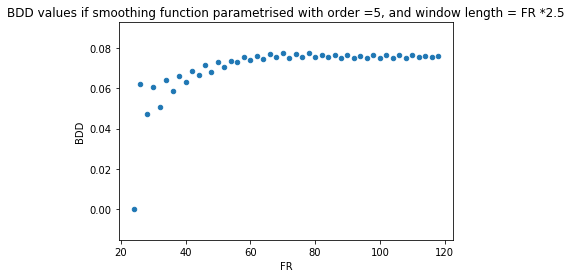

[0.0, 0.06204901081827768, 0.04721166091195306, 0.06083028676617245, 0.05097206673535152, 0.06391595652506304, 0.058811142035101426, 0.06593637092012913, 0.0633131442016925, 0.06877193848053095, 0.06665296086450606, 0.071616413565563, 0.06822423026746008, 0.07319967330990083, 0.07039308247433976, 0.07340985303107668, 0.07298097440464765, 0.07543895650560029, 0.07412634379732805, 0.07597179922369508, 0.07482025879273692, 0.07691036736955521, 0.07575605658100265, 0.07757394256323795, 0.07531013966101671, 0.07719792616807822, 0.07579407842616226, 0.07759156773029353, 0.07554056149277223, 0.07678577075408585, 0.07577761608327949, 0.07663529959537878, 0.0751509300144865, 0.07649740305671467, 0.07532451487854398, 0.07626310699811574, 0.07501897753648638, 0.07642369904398984, 0.07513988098129885, 0.07643682606774135, 0.07526615278874756, 0.07641896616077759, 0.07513722621845162, 0.07639808190963962, 0.07538859550720357, 0.07621649055402893, 0.07548166578576442, 0.07614290706564389]
LOG: Extra

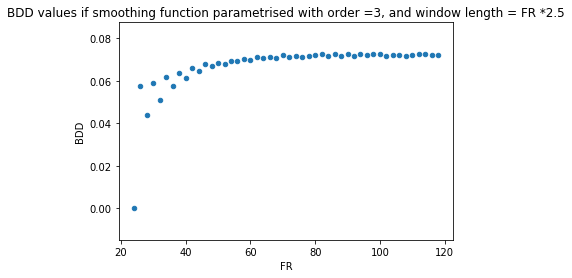

[0.0, 0.05750049512658729, 0.0440570069179755, 0.05905752990373276, 0.05120812177337068, 0.0617632210633367, 0.057512321760651866, 0.06360666709933067, 0.061540074581690606, 0.06623305388486161, 0.06478772330421002, 0.06778476774395097, 0.06693731778164716, 0.06844727569170833, 0.06810502884961968, 0.06956657941945586, 0.06919685850583758, 0.07032093342349353, 0.06985674485636571, 0.07132895080439723, 0.07085639568967665, 0.07140056169297426, 0.07089495493639729, 0.0721173172775491, 0.07117252920932515, 0.07161869642304634, 0.07150309664362126, 0.07182240815236456, 0.07203305654237709, 0.07249088021613301, 0.07173437621907311, 0.0724939398133249, 0.0719359688306304, 0.0726457320805929, 0.0718204867240842, 0.07253559528268753, 0.07234176040663667, 0.07263107343580631, 0.07250984748226078, 0.07182650926955043, 0.07227426326577764, 0.07209977171379786, 0.07195138383988503, 0.07224069730301119, 0.07248726429589812, 0.07266121766703439, 0.07215312867883752, 0.07201622073016485]


In [41]:
computeBDDs(44, 'high', 5, 2.5)
computeBDDs(44, 'high', 3, 2.5)
#negligible difference, same and high BDD for both (so I guess smoothing doesn't solve the problem for curve 44, 
#maybe it's due to normalisation)

In [ ]:
#preliminary result:
#for ord 3 the BDD curves are smoother and have the expected shape as they converge to some value 
#(but sometimes BDD is higher than for ord 5: in cases where the BDD plot for ord 5 was already quite smooth

#for order 3 there is less variation how curves are smoothed for different FR (because the range of shapes is more limited)
#but accuracy decreases



LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

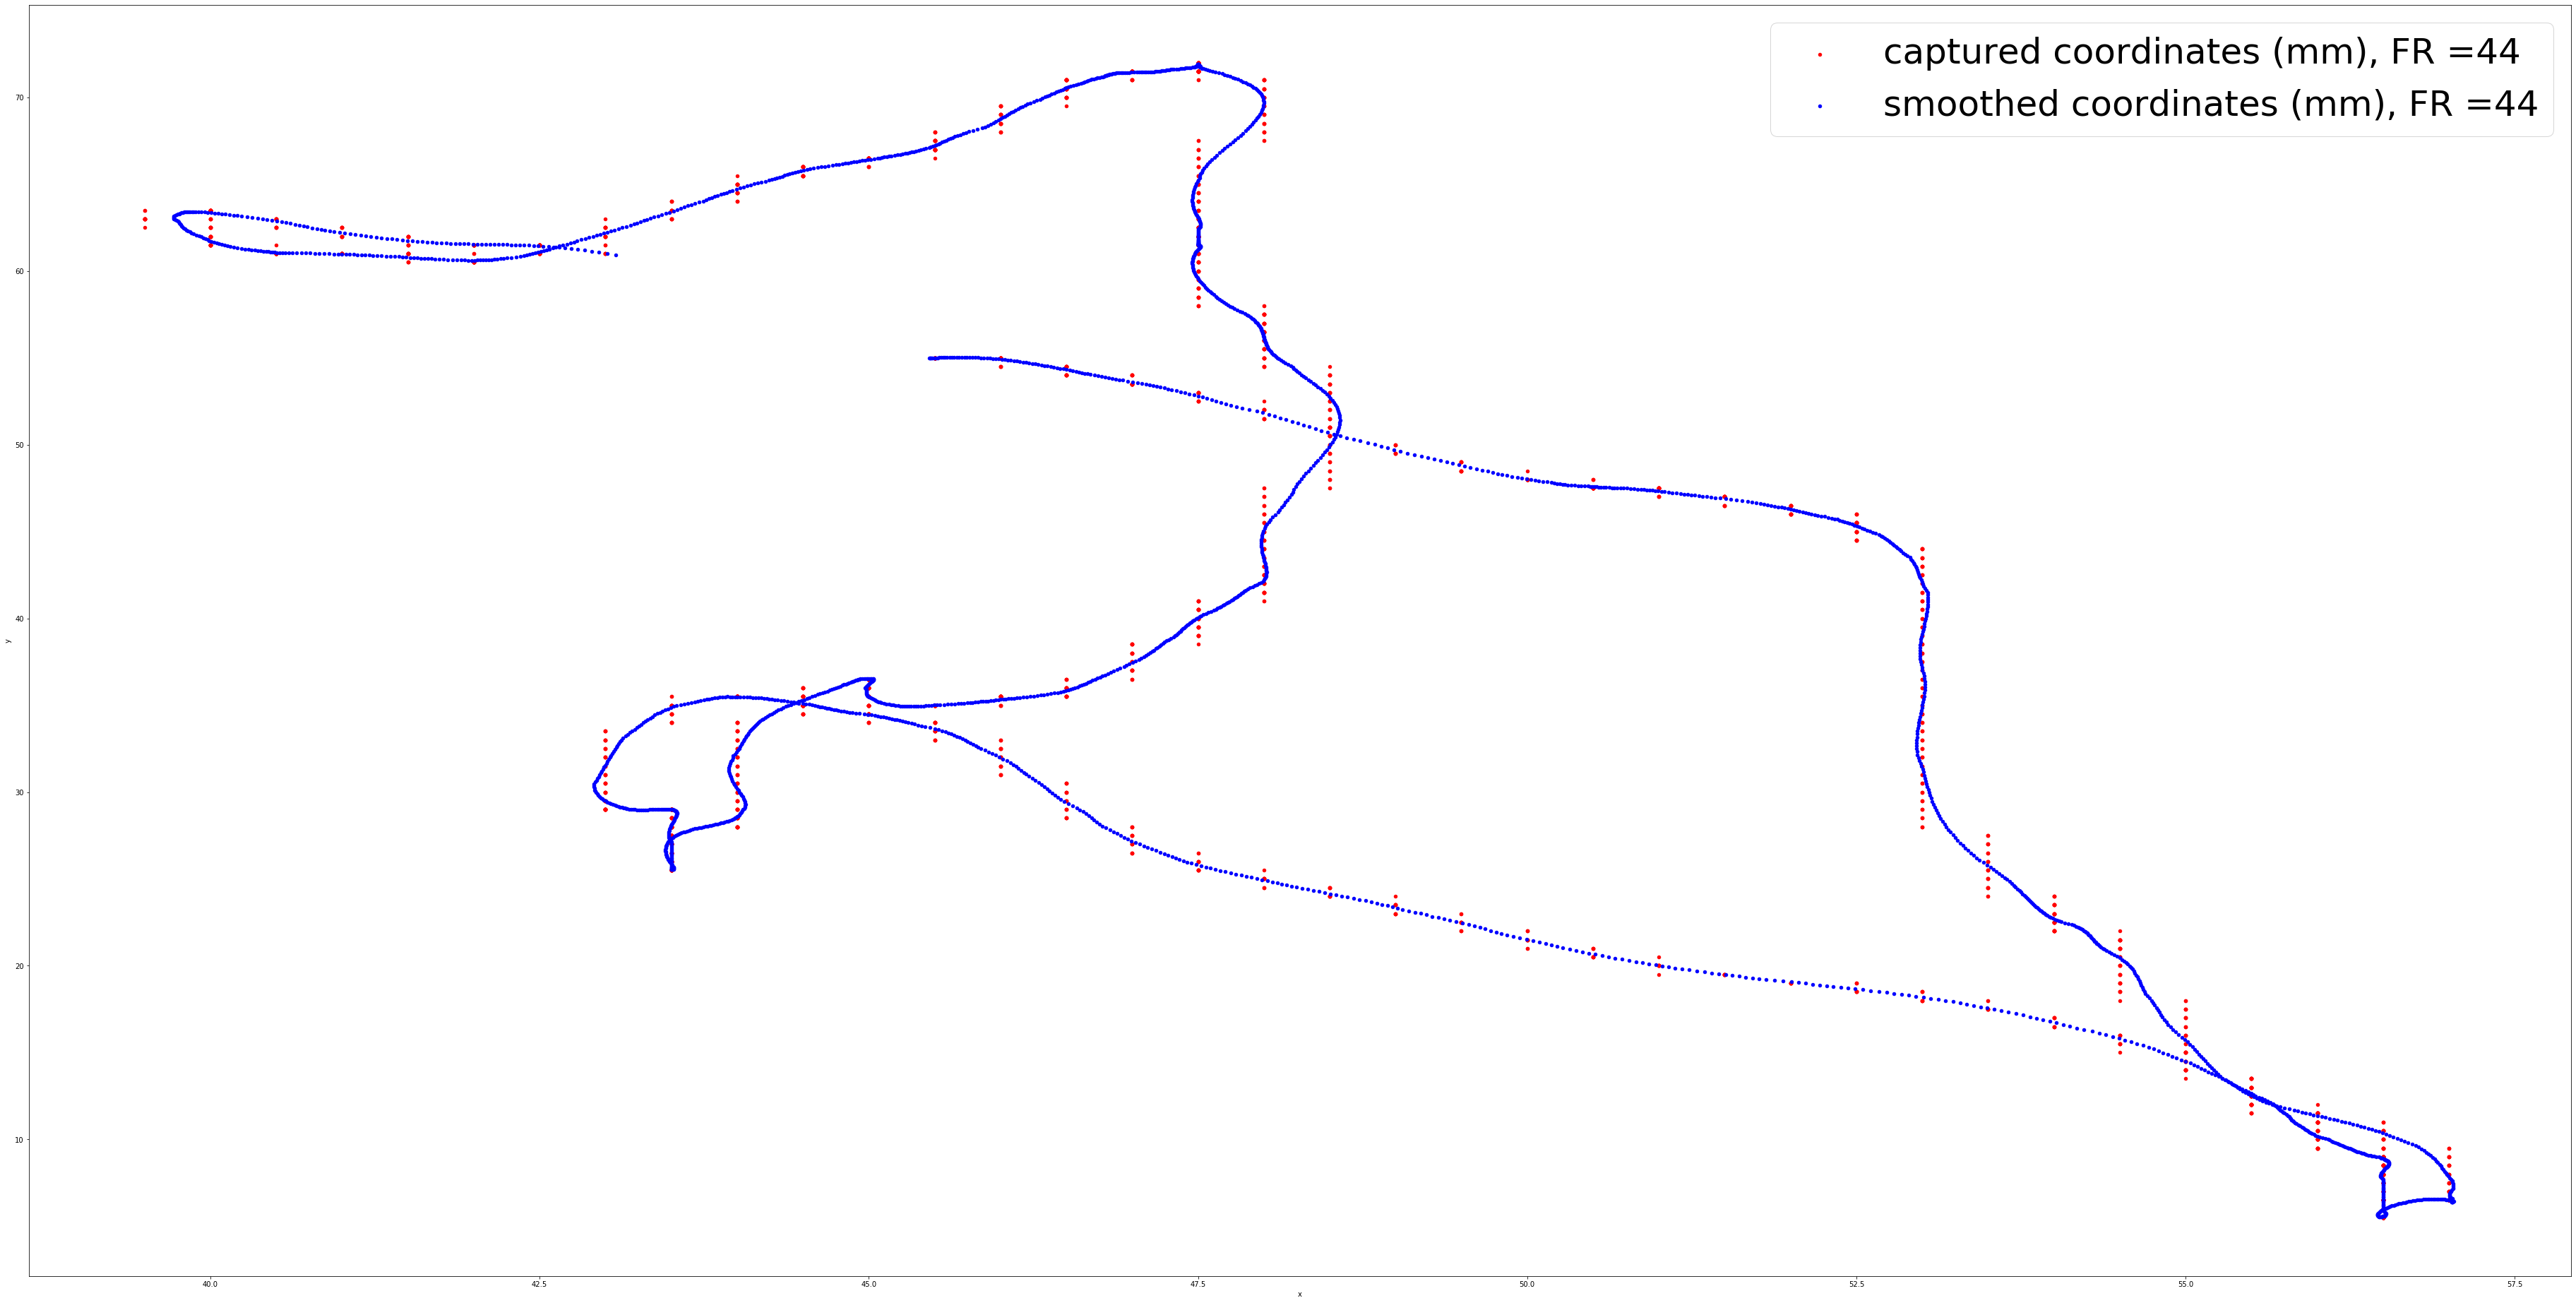

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

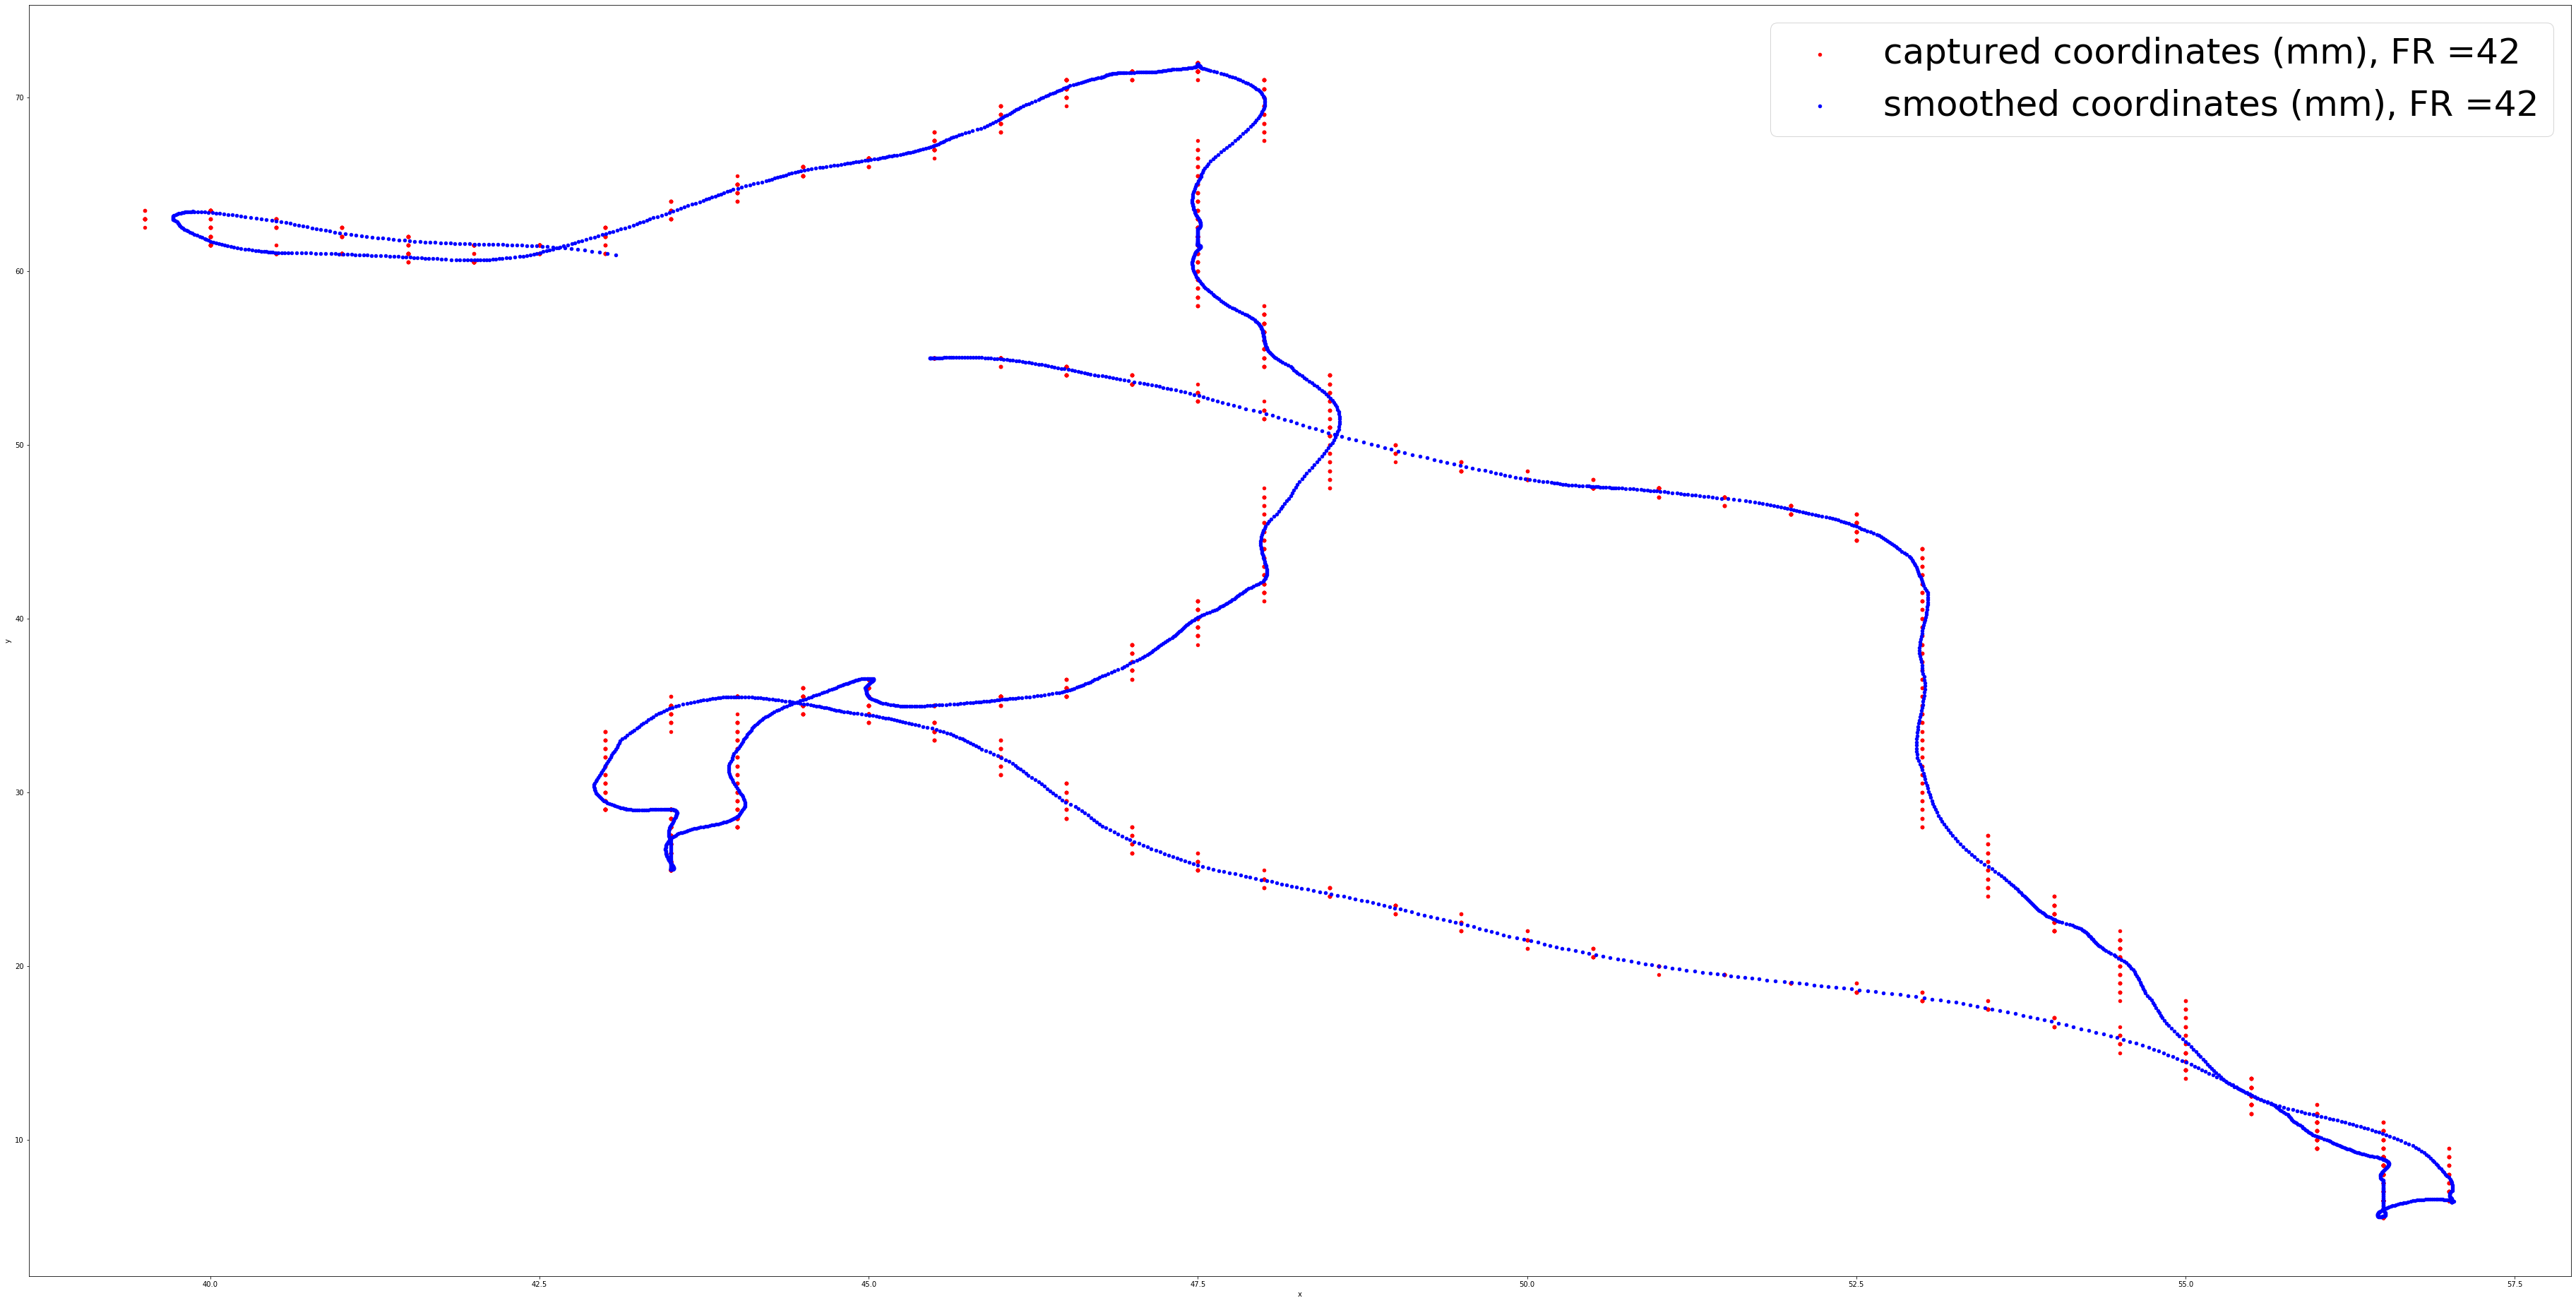

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

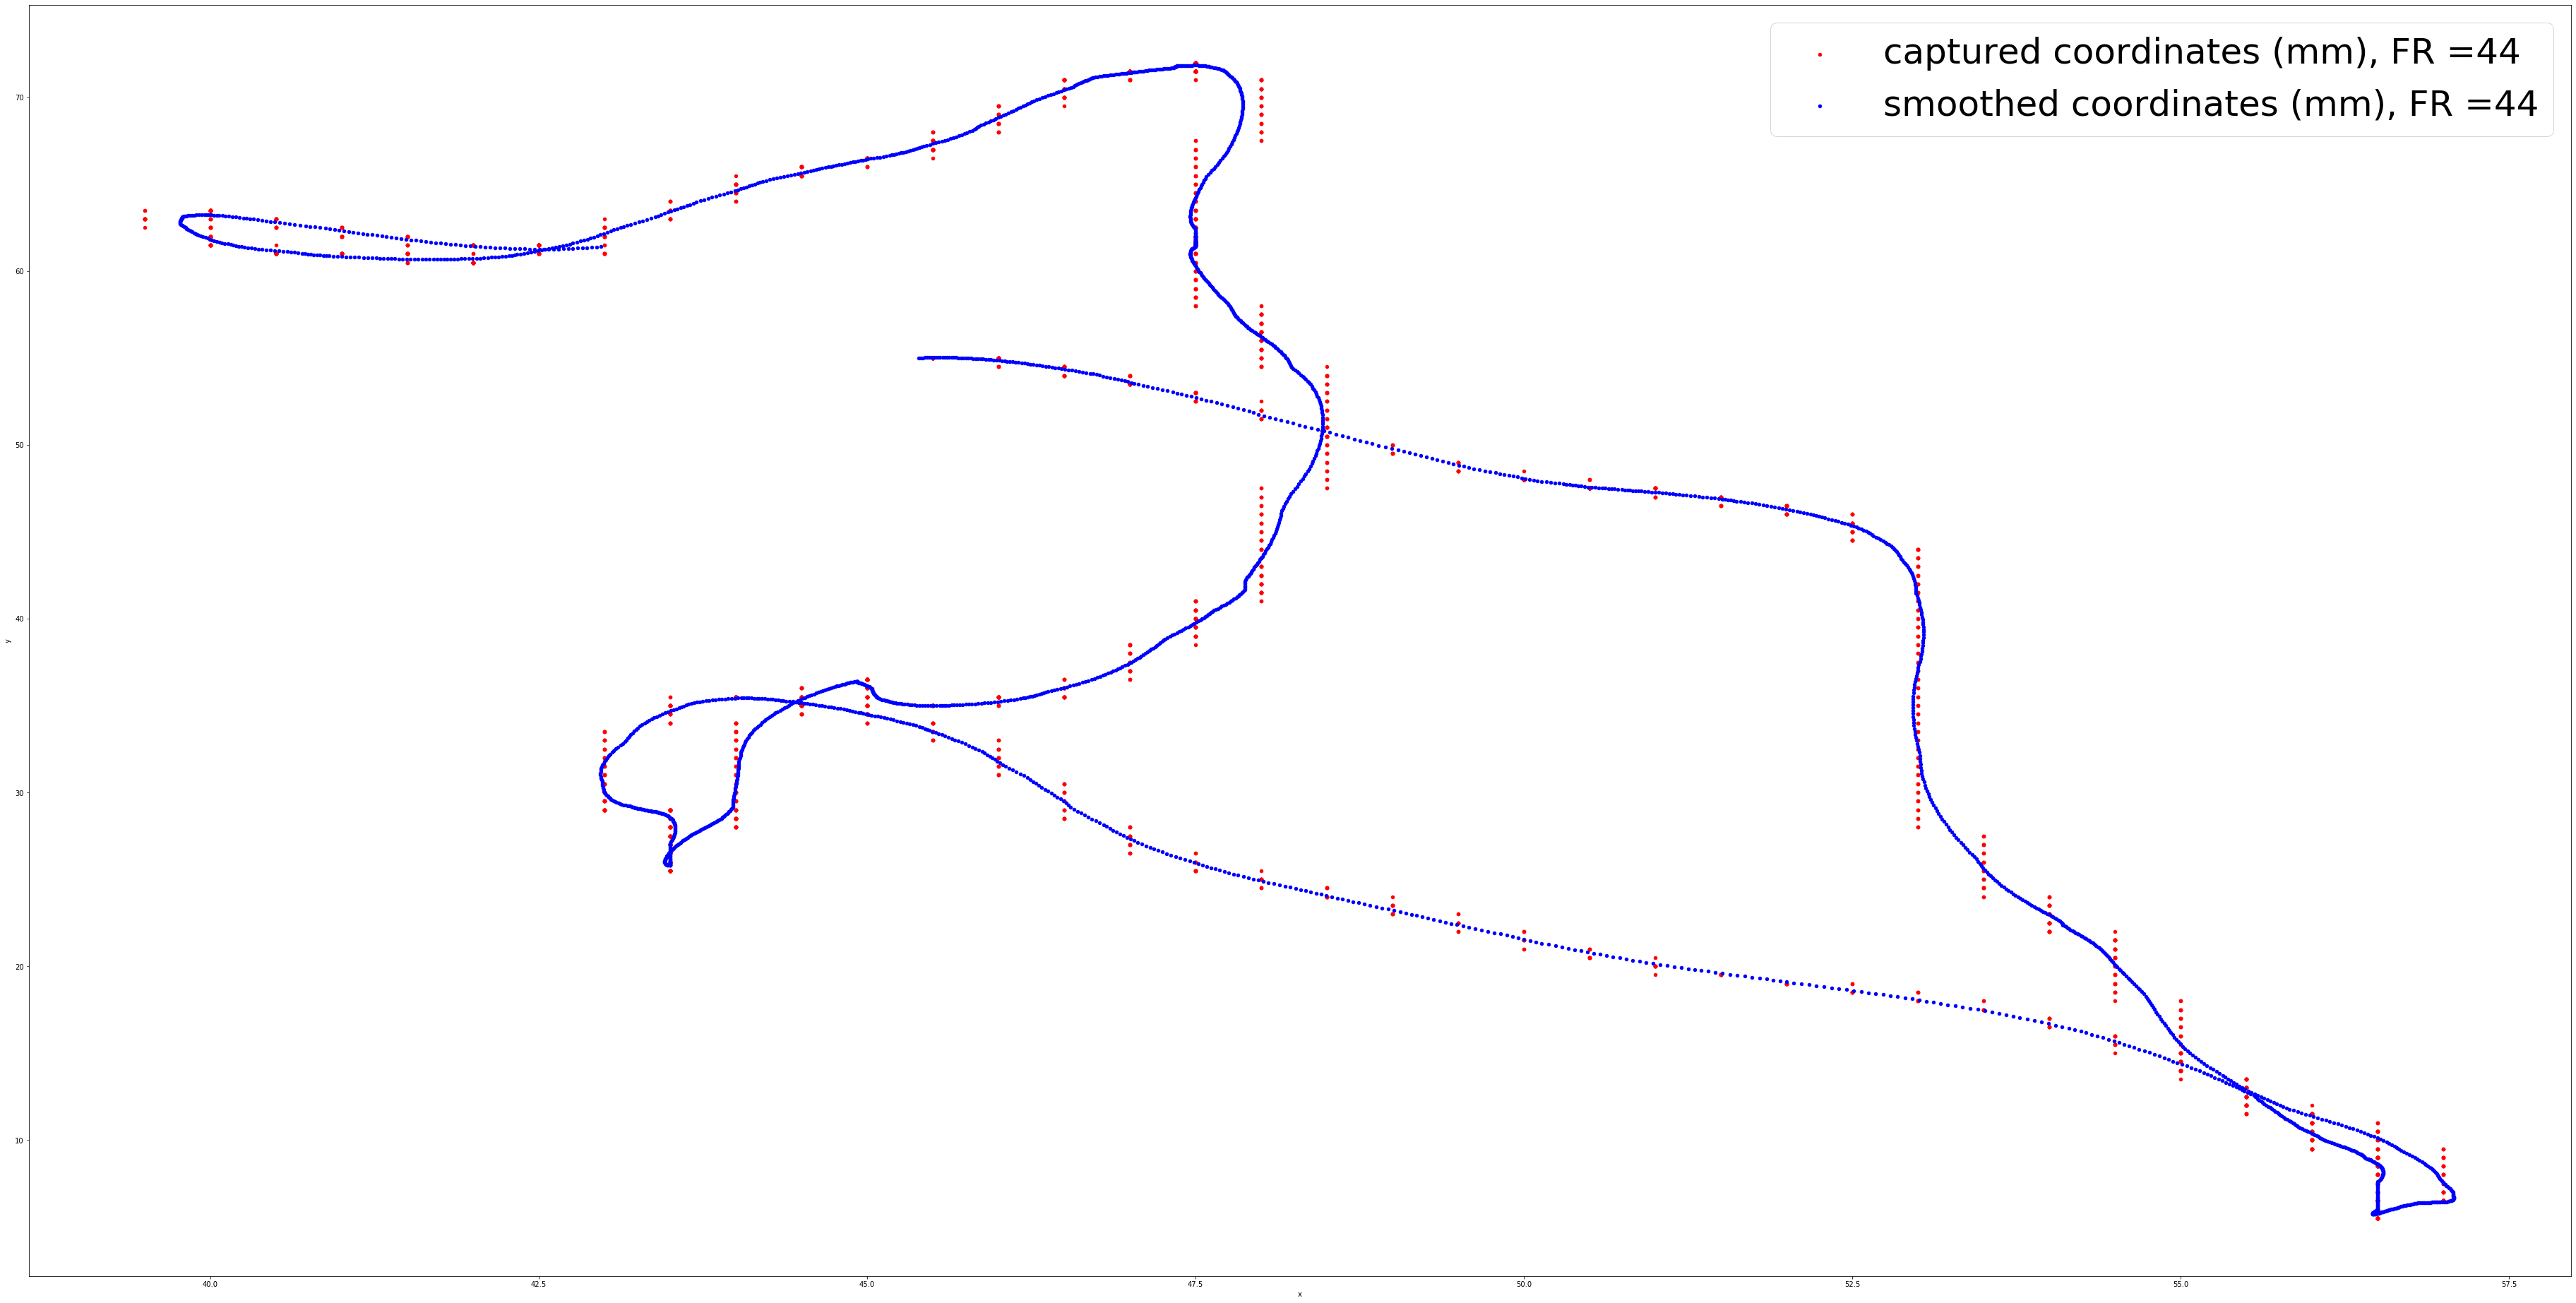

LOG: Extracting coordinates for Animal CRV_34_TEST_CTRL...
LOG: Extracting coordinates for Animal CRV_34_TEST_00...
LOG: Extracting coordinates for Animal CRV_34_TEST_01...
LOG: Extracting coordinates for Animal CRV_34_TEST_02...
LOG: Extracting coordinates for Animal CRV_34_TEST_03...
LOG: Extracting coordinates for Animal CRV_34_TEST_04...
LOG: Extracting coordinates for Animal CRV_34_TEST_05...
LOG: Extracting coordinates for Animal CRV_34_TEST_06...
LOG: Extracting coordinates for Animal CRV_34_TEST_07...
LOG: Extracting coordinates for Animal CRV_34_TEST_08...
LOG: Extracting coordinates for Animal CRV_34_TEST_09...
LOG: Extracting coordinates for Animal CRV_34_TEST_10...
LOG: Extracting coordinates for Animal CRV_34_TEST_11...
LOG: Extracting coordinates for Animal CRV_34_TEST_12...
LOG: Extracting coordinates for Animal CRV_34_TEST_13...
LOG: Extracting coordinates for Animal CRV_34_TEST_14...
LOG: Extracting coordinates for Animal CRV_34_TEST_15...
LOG: Extracting coordinates f

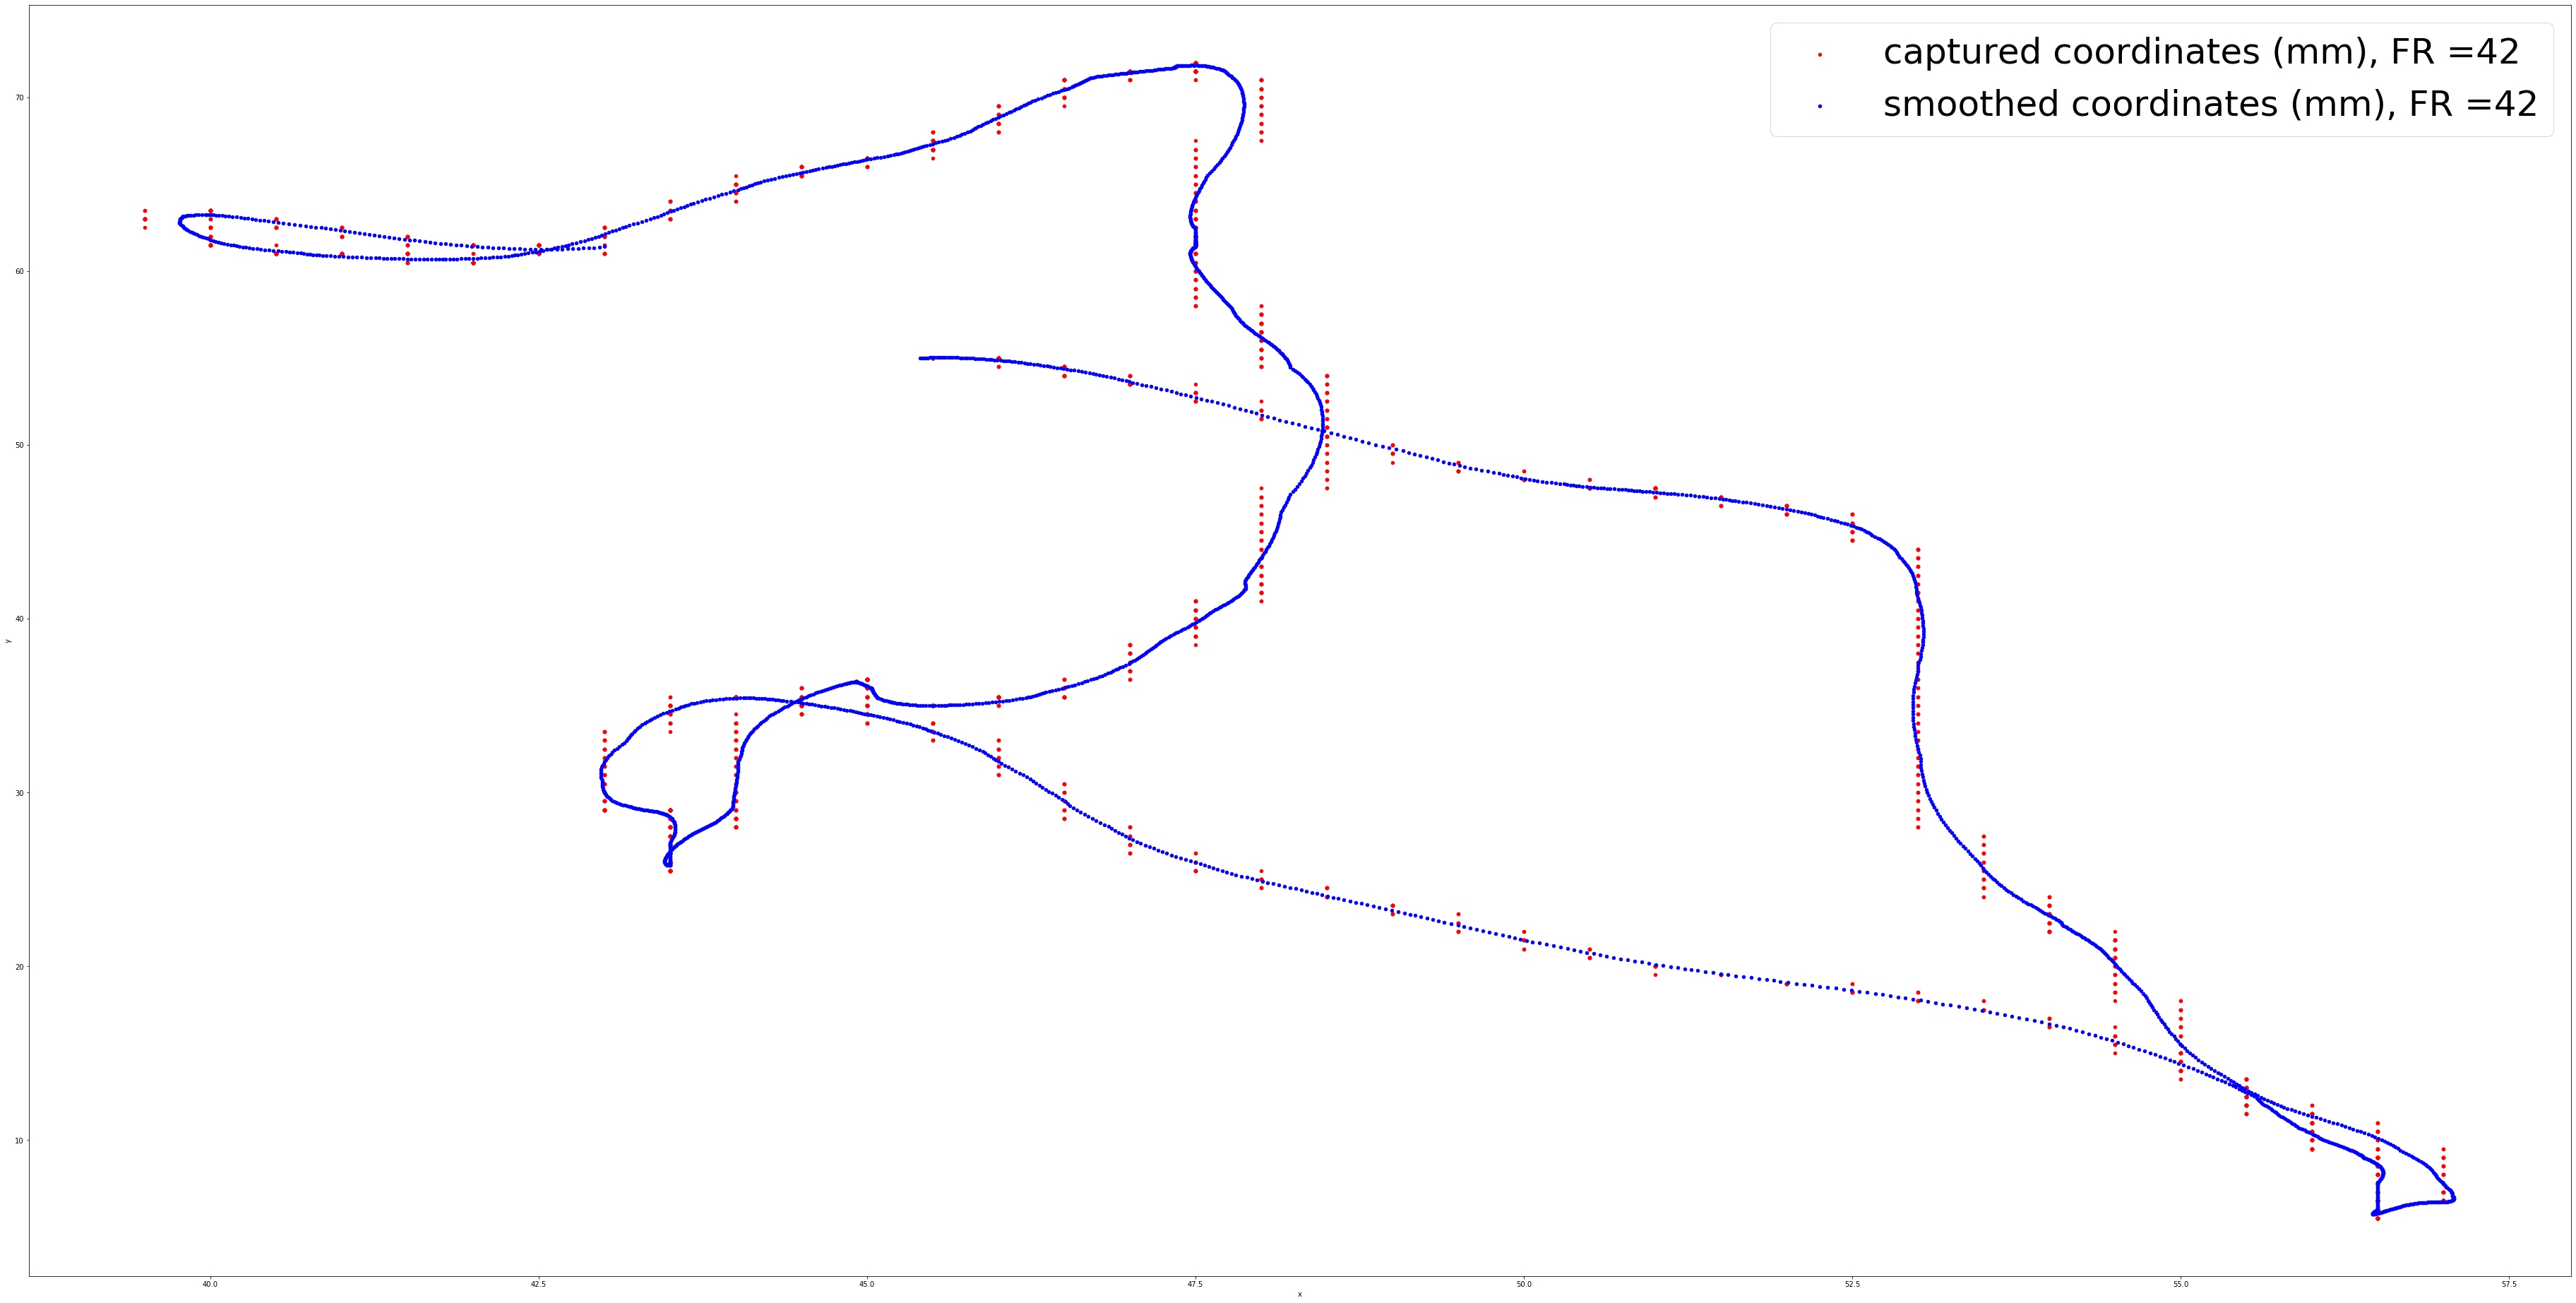

In [46]:
PlotCurve(34, 44, 5, 2.5)
PlotCurve(34, 42, 5, 2.5)

PlotCurve(34, 44, 3, 2.5)
PlotCurve(34, 42, 3, 2.5)

#window length ie. c should be smaller
#for order 3 the shapes might be more similar but we are losing some accuracy as in the last 2 plots
#some curves are far from the original coordinates
#would be useful to plot the original curve

In [ ]:
#edit and import capture_and_compare to get a plotting function for the generated smooth curves from there